# Table of Contents

1. Data Preprocessing

2. Feature Engineering

3. Model Building

4. Model Evaluation (make prediciton on the holdout dataset as well)

5. Prediction Interpretation

6. Recommendation

---

In [1]:
# import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pickle
import tensorflow as tf
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from sklearn.base import TransformerMixin
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
import matplotlib.patches as mpatches
import dalex as dx

In [2]:
from utils import you_never_know_where_it_is as ynk
import importlib
importlib.reload(ynk)
from utils.you_never_know_where_it_is import DataPreprocessor, PerformanceMetrics, create_metrics_dataframe, create_stacking_classifier


# I. Data Preprocessing

In [3]:
df = pd.read_csv('./data/loan_train.csv')

Let's write a class to write all the data preprocessing steps.

Some plot functions

## I.1 Basic Overview Analysis

Eyeball data, check missing values, duplicates

In [4]:
# df.info()


`Check duplicates`

In [5]:
# check duplicates
df.duplicated().sum()

# remove duplicates 
df = df.drop_duplicates()


`Check missing values`

In [6]:
# missing values as a percentage
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)

In [7]:
# number of missing cols containing missing values
print('number of cols containing missing values:', len(missing_values))

# number of missing values in the loan_status 
print('number of missing values in the loan_status:', df['loan_status'].isnull().sum())

number of cols containing missing values: 51
number of missing values in the loan_status: 0


Apparently, all cols contain missing values except the label. This is quite annoying

Here is the plan to deal with missing values:
- if the missing values are less than 1% of the total, we can drop the rows 

- if the missing values are less than 10% of the total we can do some further investigation to see if it's appropriate to fill these missing values with median or mode 

- If the missing values are greater than 10%, let's investigation to see if there is a reason for the missing values. If not, we can decide to drop some cols wikth extremely high missing values

In [8]:
# get the index for those have value less than 1% in missing_values
small_missing_values= missing_values[missing_values < 1].index

small_missing_values.tolist()

# drop the rows with missing values in the small_missing_values
df = df.dropna(subset=small_missing_values)

In [9]:
# check the remaining missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)
missing_values

next_pymnt_d              92.307172
mths_since_last_record    91.593369
mths_since_last_delinq    63.606225
desc                      31.725304
emp_title                  6.062246
pub_rec_bankruptcies       2.919486
emp_length                 2.547361
dtype: float64

These faetures are a bit complicated, and require careful handling. Thus, we will take care of them in **feature engineering** 

## I.2 Univariate Analysis

In [10]:
# initialize the DataPreprocessor
dp = DataPreprocessor()

### I.2.1 Numerical Features

Visualize histogram of all these numerical features to see the distribution of the data and check for outliers as well as invalid numerical features. Some of them could be potential categorical features instead

In [11]:
# extract numerical features from the dataset 
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

In [12]:
# ynk.analyze_numerical(df, numerical_features)

It appears that none of them follows a normal distribution. Some distribution is quite suspicious and we need to investigate further.

Some of these variables have just ONE value in the entire column. we can consider removing these columns as they don't provide any information.

- Here is the list of useless numerical cols that don't provide any good information:

In [13]:
useless_cols = ['chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_amnt', 'tax_liens', 'policy_code', 'acc_now_delinq', 'total_rec_late_fee']

Let's just drop them to make our life easier

In [14]:
df = dp.drop_useless_numerical_cols(df)

Some cols are actually numerical but they are in the categorical form. We need to convert them to numerical form

In [15]:
# df = dp.convert_interest_rate_to_numerical(df)

There are still some issues that we need to address, but we can take care of them later in the feature engineering section. Let's just now move on to the categorical section


### 1.2.2 Categorical Features

In [16]:
# extract categorical features from the dataset
categorical_features = df.select_dtypes(include=[object]).columns.tolist()

# check the number of levels in these features 
for col in categorical_features:
    print(f"{col}: {df[col].nunique()}")

term: 2
int_rate: 389
grade: 7
sub_grade: 35
emp_title: 21998
emp_length: 11
home_ownership: 5
verification_status: 3
issue_d: 53
loan_status: 2
desc: 20151
purpose: 14
addr_state: 50
earliest_cr_line: 516
revol_util: 1093
next_pymnt_d: 95
last_credit_pull_d: 106


`Low Cardinality` (Less than 10 unique values)

In [17]:
low_card =  ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status']

term
36 months    74.3%
60 months    25.7%
Name: proportion, dtype: object


grade
B    29.03%
A    24.07%
C    20.35%
D    14.29%
E     7.99%
F     3.02%
G     1.24%
Name: proportion, dtype: object


home_ownership
RENT        47.15%
MORTGAGE     44.9%
OWN          7.64%
OTHER         0.3%
NONE         0.01%
Name: proportion, dtype: object


verification_status
Not Verified       43.87%
Verified            31.9%
Source Verified    24.23%
Name: proportion, dtype: object


loan_status
current    85.18%
default    14.82%
Name: proportion, dtype: object




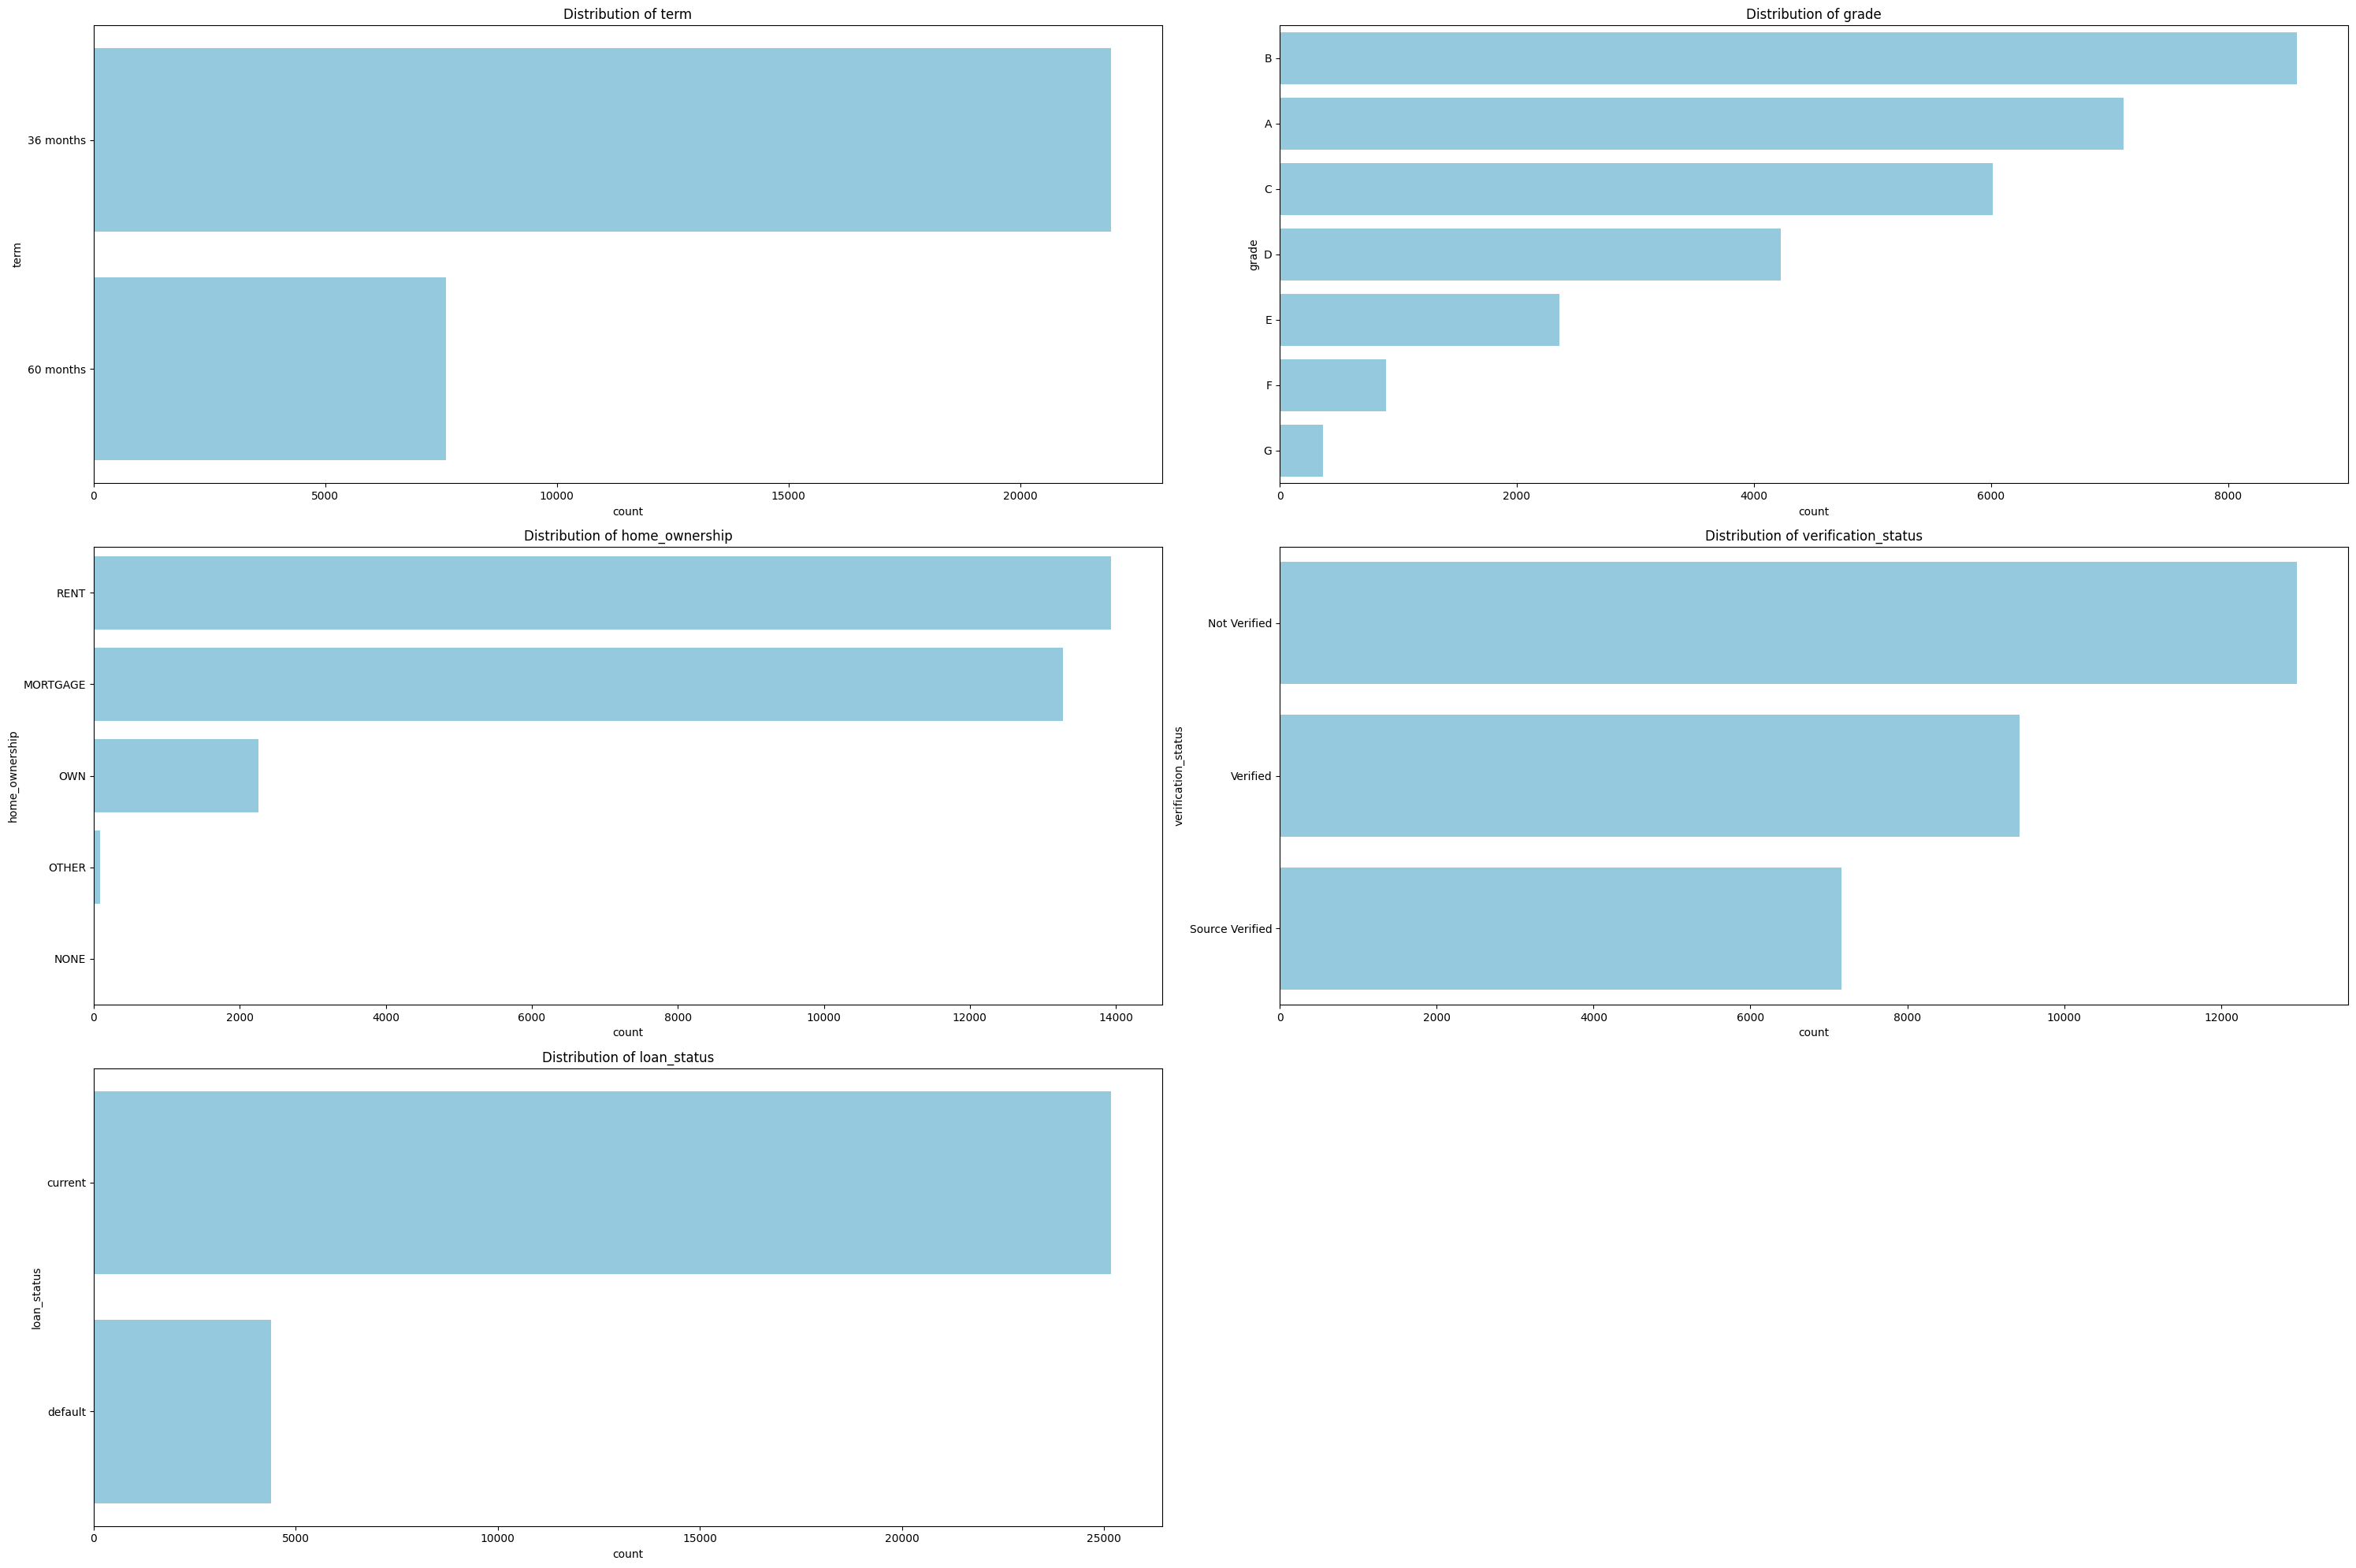

In [18]:
ynk.visualize_categorical(df, low_card, figsize=(30, 20))

Potential transformation needed: home_ownership

`Med Cardinality`

In [19]:
med_card = ['sub_grade', 'emp_length', 'purpose', 'addr_state']

sub_grade
B3    7.05%
A4     6.9%
A5     6.6%
B5     6.5%
B4    5.95%
C1    5.38%
B2    5.01%
C2    4.89%
B1    4.52%
A3     4.2%
C3    3.95%
A2    3.72%
D2    3.61%
C4    3.15%
D3    3.09%
C5    2.98%
D4     2.7%
A1    2.66%
D1     2.5%
D5    2.41%
E1    2.05%
E2    1.86%
E3    1.59%
E4    1.31%
E5    1.18%
F1    0.92%
F2     0.7%
F3    0.59%
F4    0.48%
F5    0.34%
G1    0.34%
G4    0.25%
G2    0.24%
G5    0.21%
G3     0.2%
Name: proportion, dtype: object


emp_length
10+ years    22.77%
< 1 year     11.92%
2 years      11.42%
3 years      10.39%
4 years       8.83%
1 year         8.7%
5 years       8.43%
6 years       5.81%
7 years        4.5%
8 years       3.88%
9 years       3.35%
Name: proportion, dtype: object


purpose
debt_consolidation    46.53%
credit_card           12.93%
other                 10.36%
home_improvement       7.48%
major_purchase         5.52%
small_business         4.66%
car                    3.77%
wedding                2.36%
medical                1.78%
mo

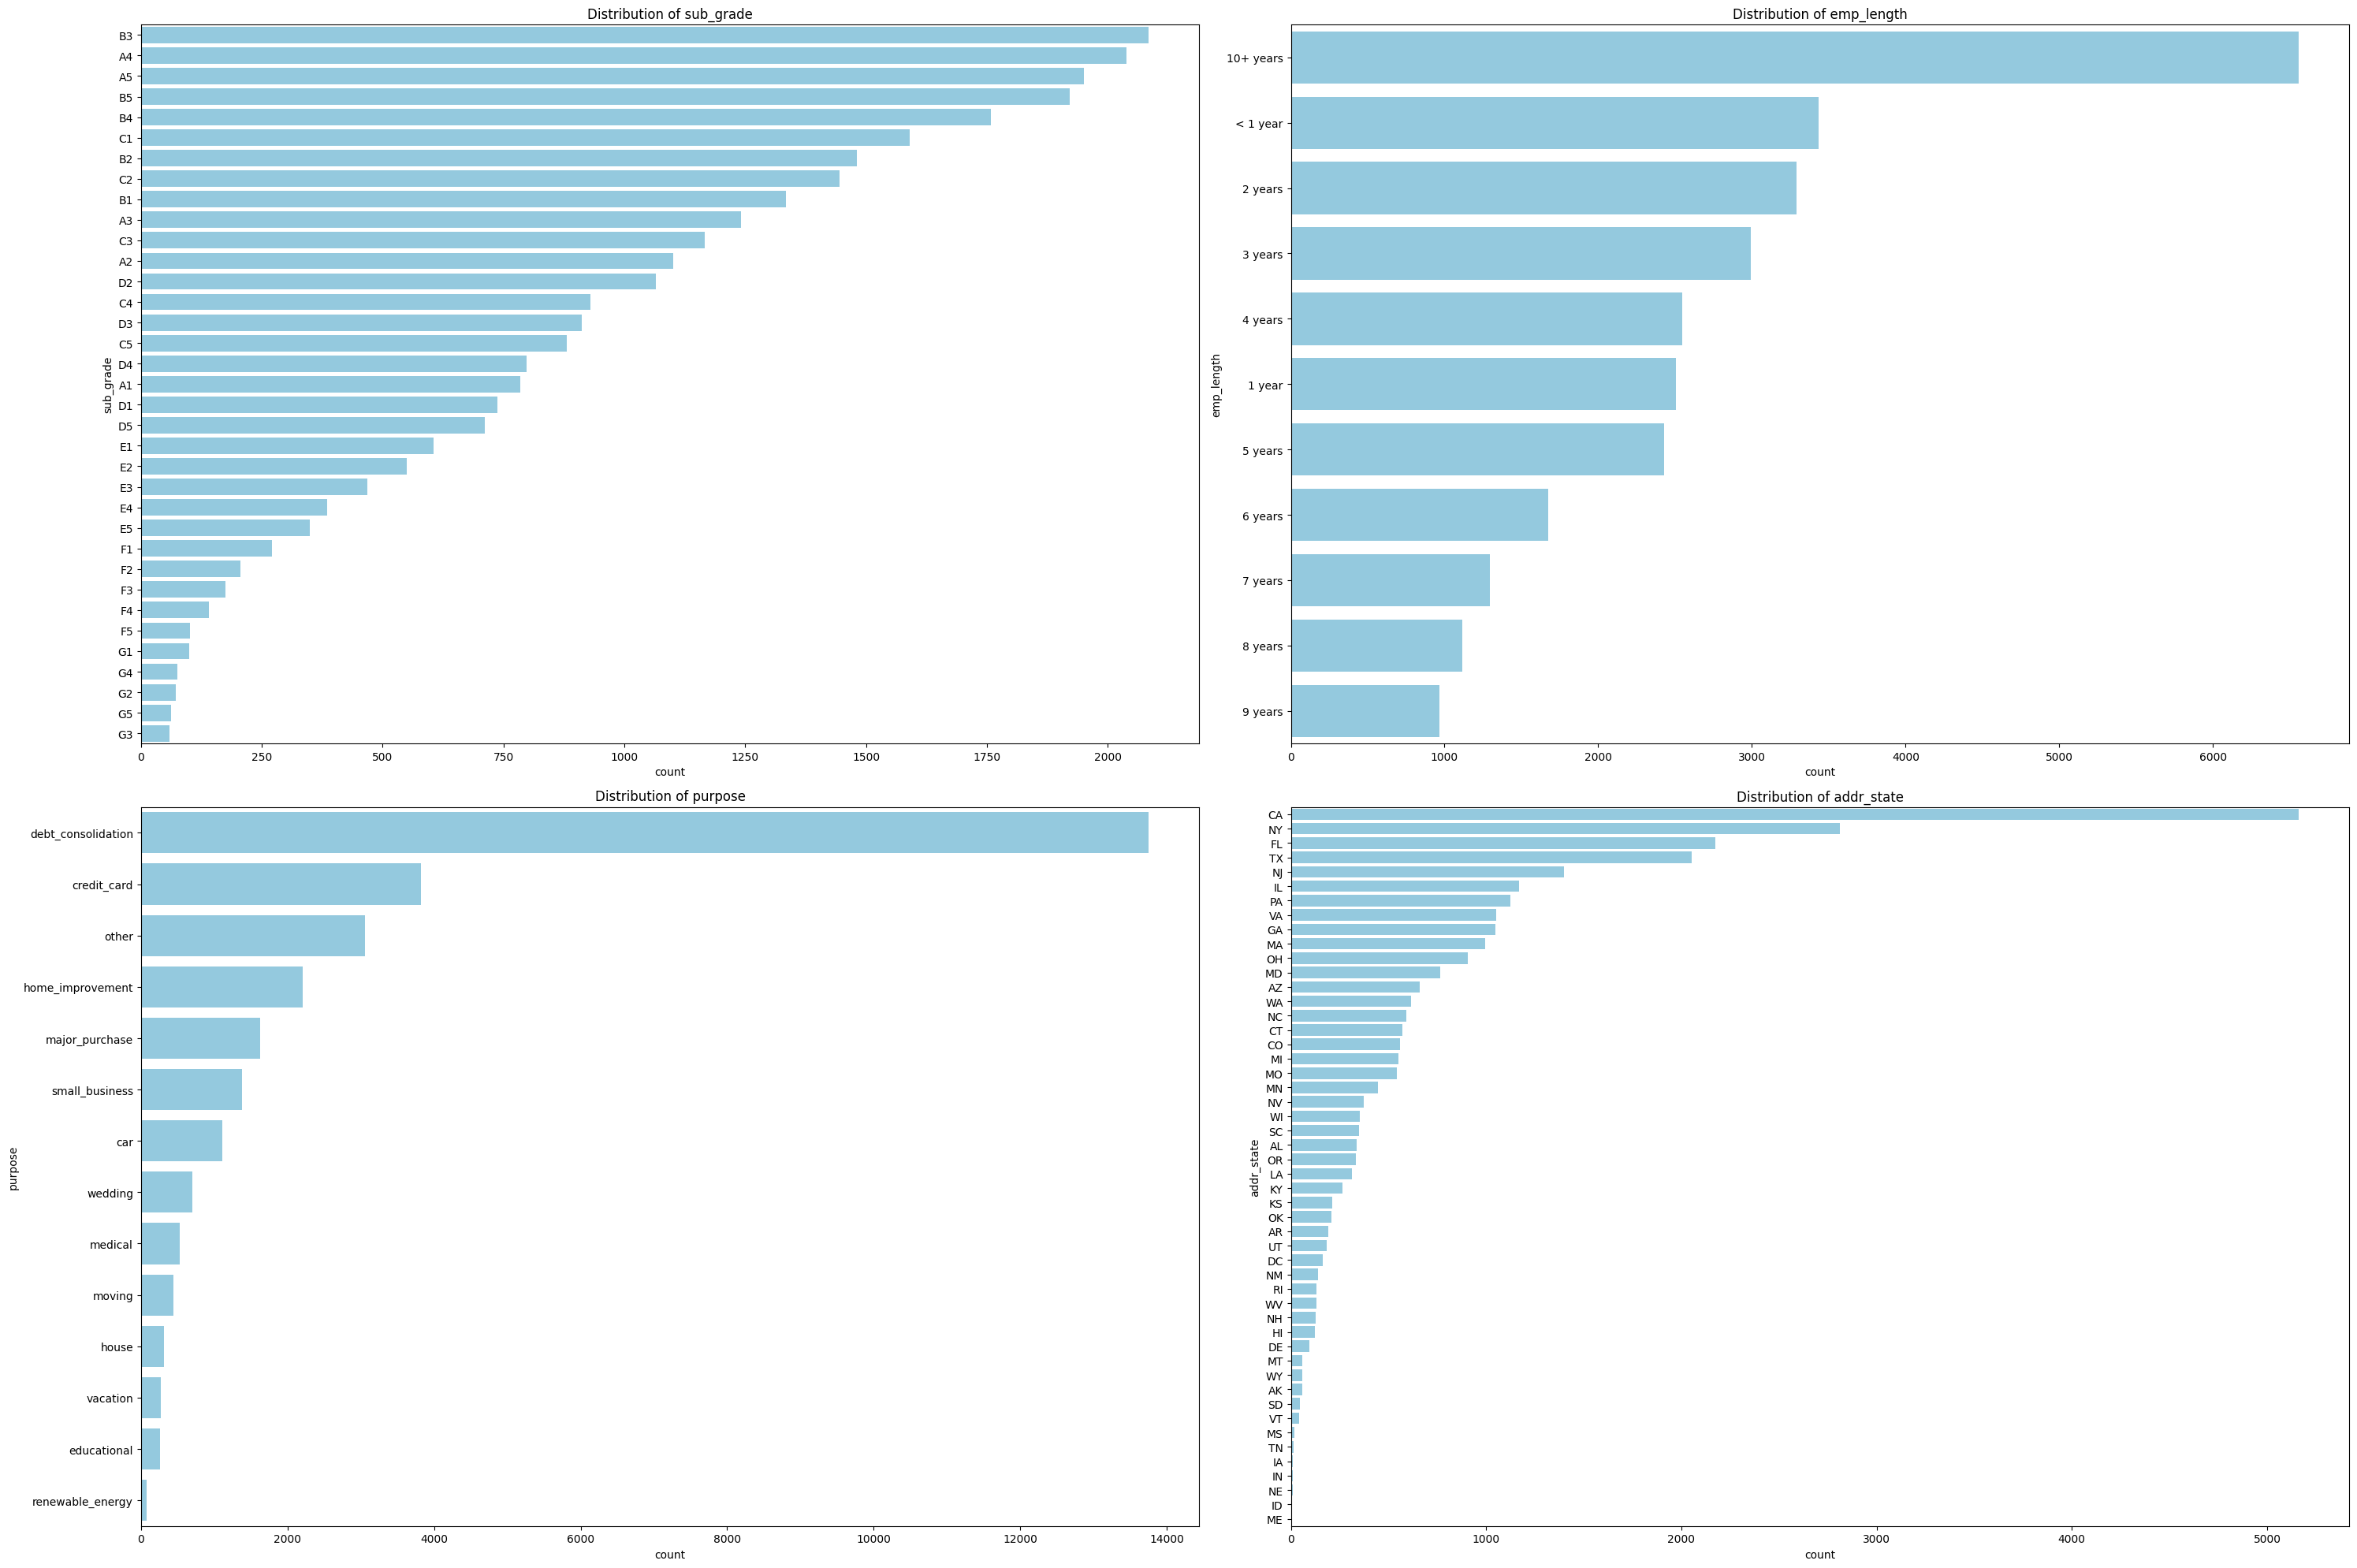

In [20]:
ynk.visualize_categorical(df, med_card, figsize=(30, 20))

`Large Cardinality `

In [21]:
large_card = ['issue_d', 'desc', 'earliest_cr_line', 'next_pymnt_d', 'last_credit_pull_d', 'emp_title']

In [22]:
# unique values in these features
for col in large_card:
    print(f"{col}: {df[col].nunique()}")

issue_d: 53
desc: 20151
earliest_cr_line: 516
next_pymnt_d: 95
last_credit_pull_d: 106
emp_title: 21998


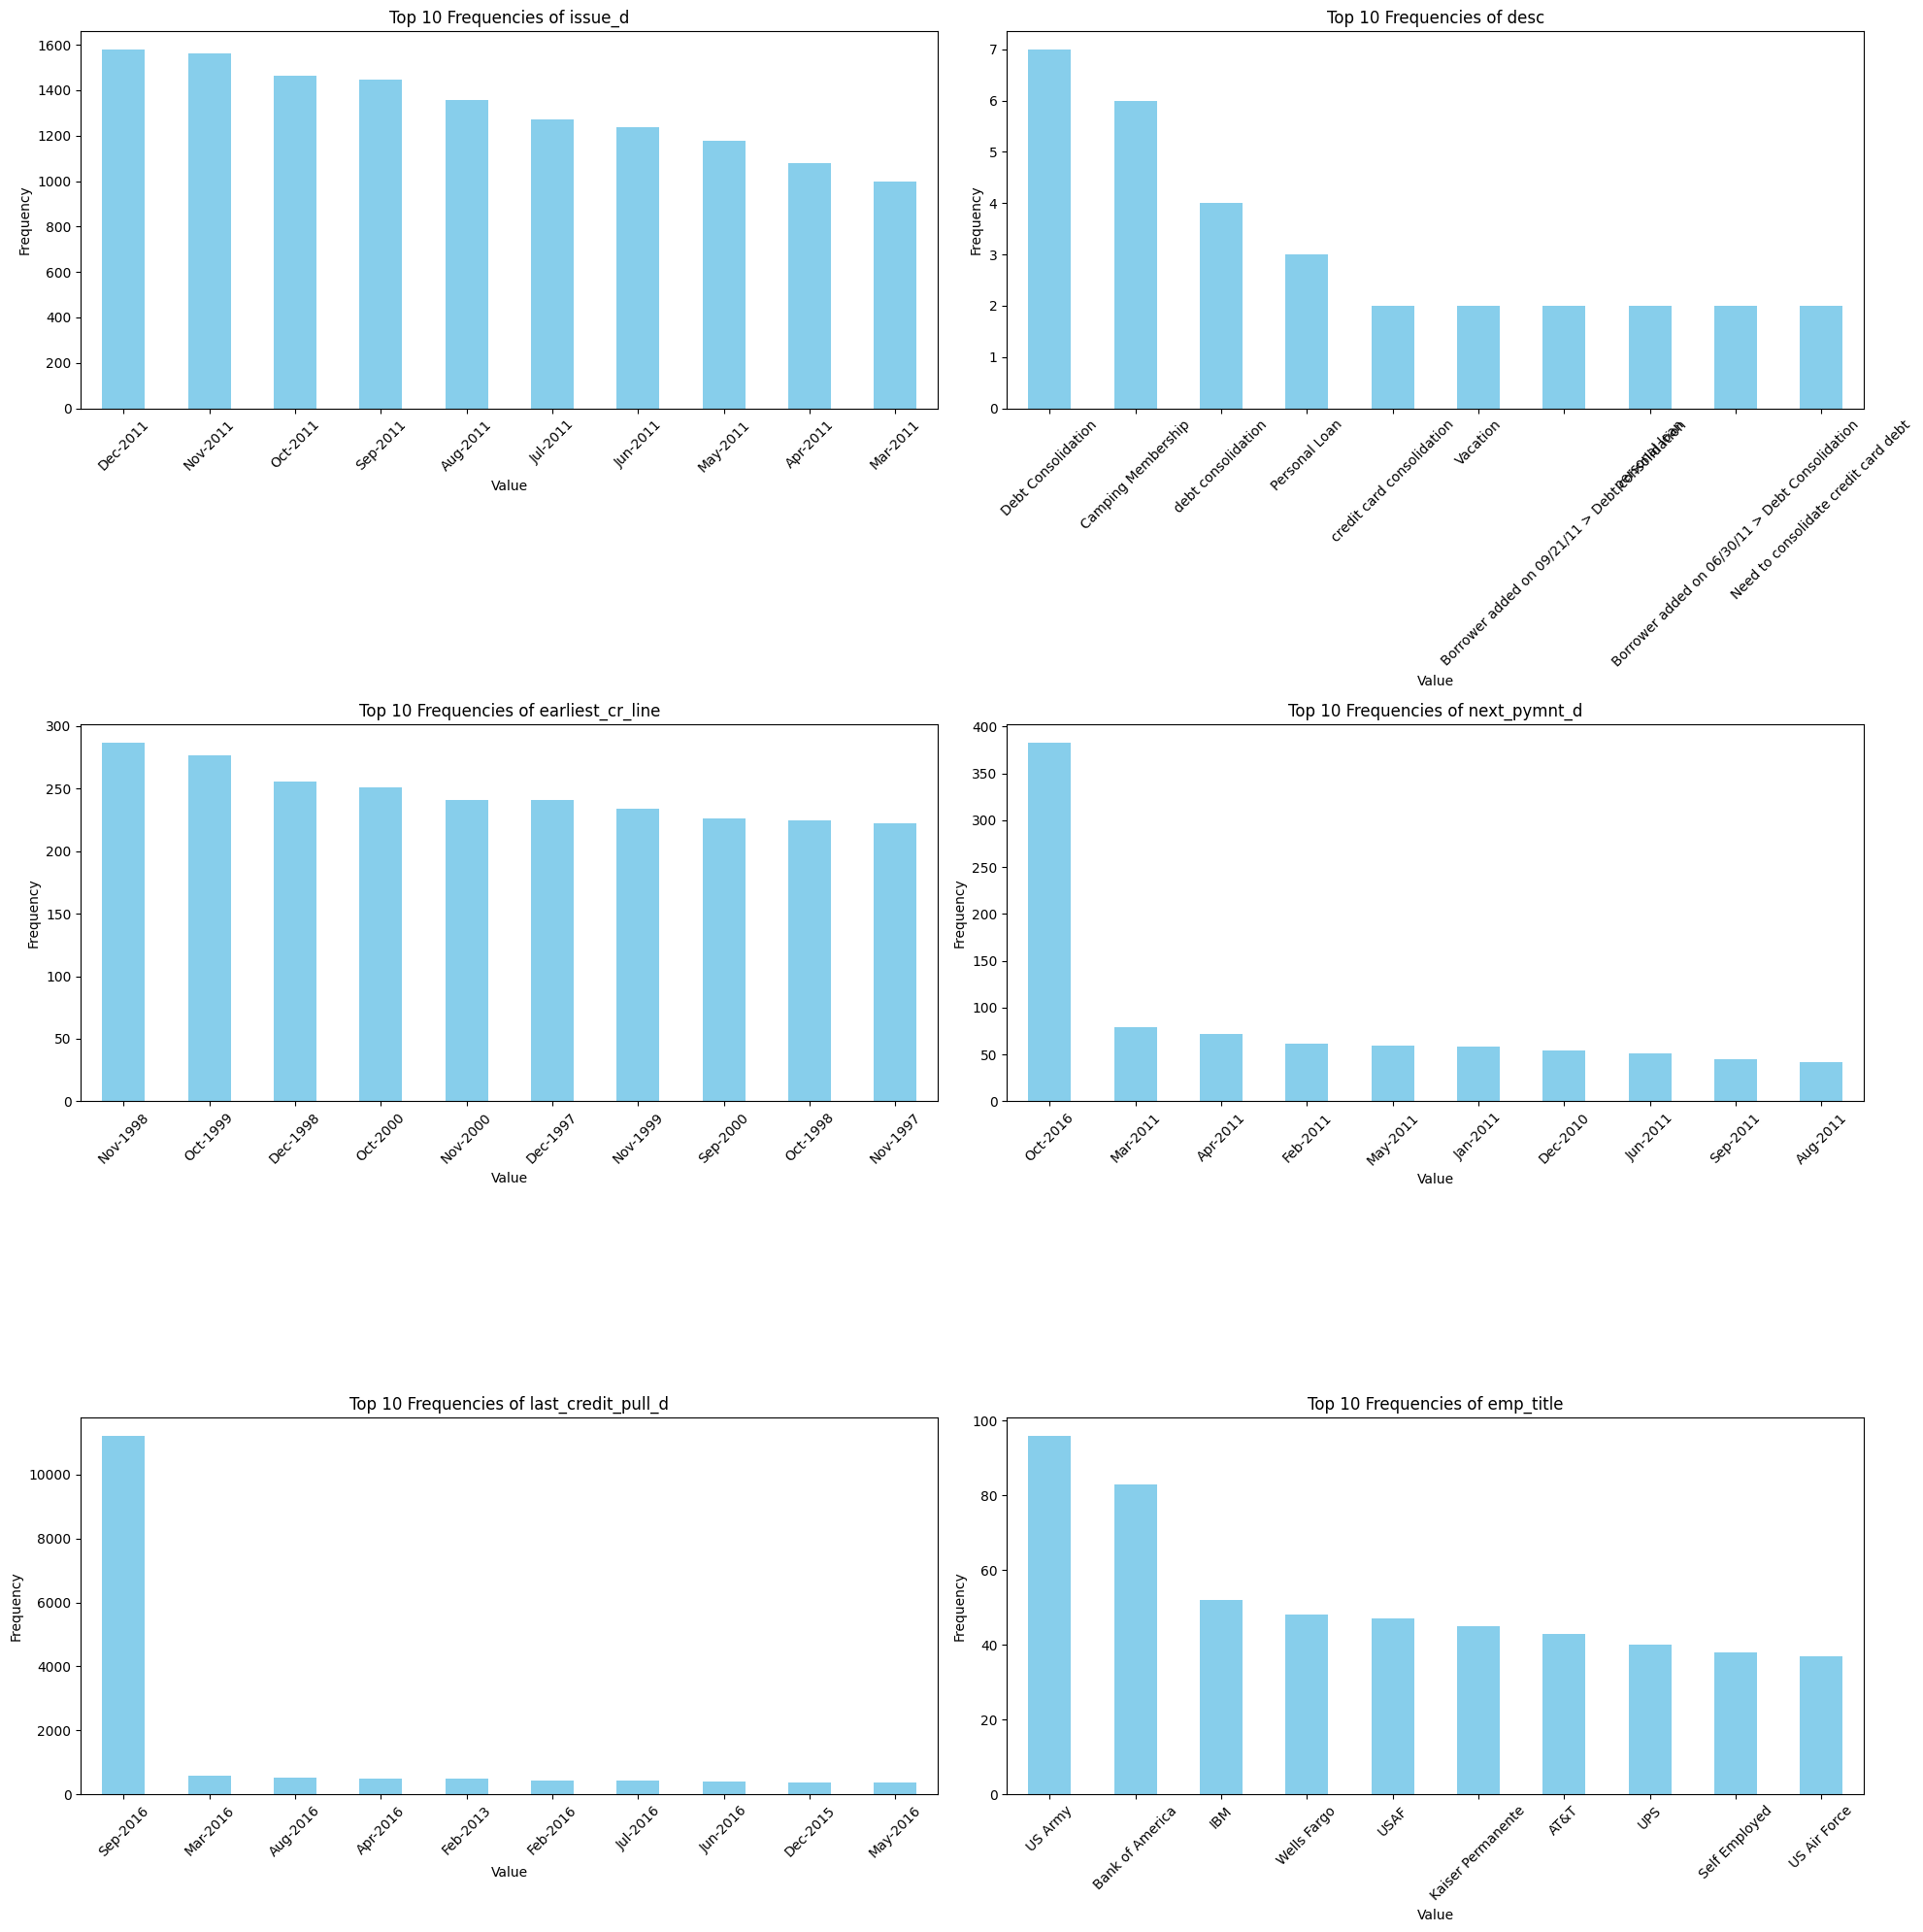

In [23]:
ynk.plot_top_10_frequencies(df, large_card)

The majority of title is debt consolidation and debt consolidation loan. On the other hand, Oct 2016 is the most frequent next_pymnt_d. Also, an overwhelming majority of last_credit_pull_d is Sep 2016

## I.3 Bivariate Analysis

Explore the relationship between the target variable (loan_status) and other features

In [24]:
# update numerical feature list 
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

The distribution between target variabel and other numerical features is quite similar. However, we can still spot a few difference. For example, the median interest rate for default loan is slightly higher than that of current loan. Meanwhile, fico_range_high is lower for default loan than that of current loan 

`Numerical Features and Target Variable`

In [25]:
# ynk.plot_boxplot_and_histogram(df, numerical_features, 'loan_status')

`Categorical Features and Target Variable`

Low Cardinality

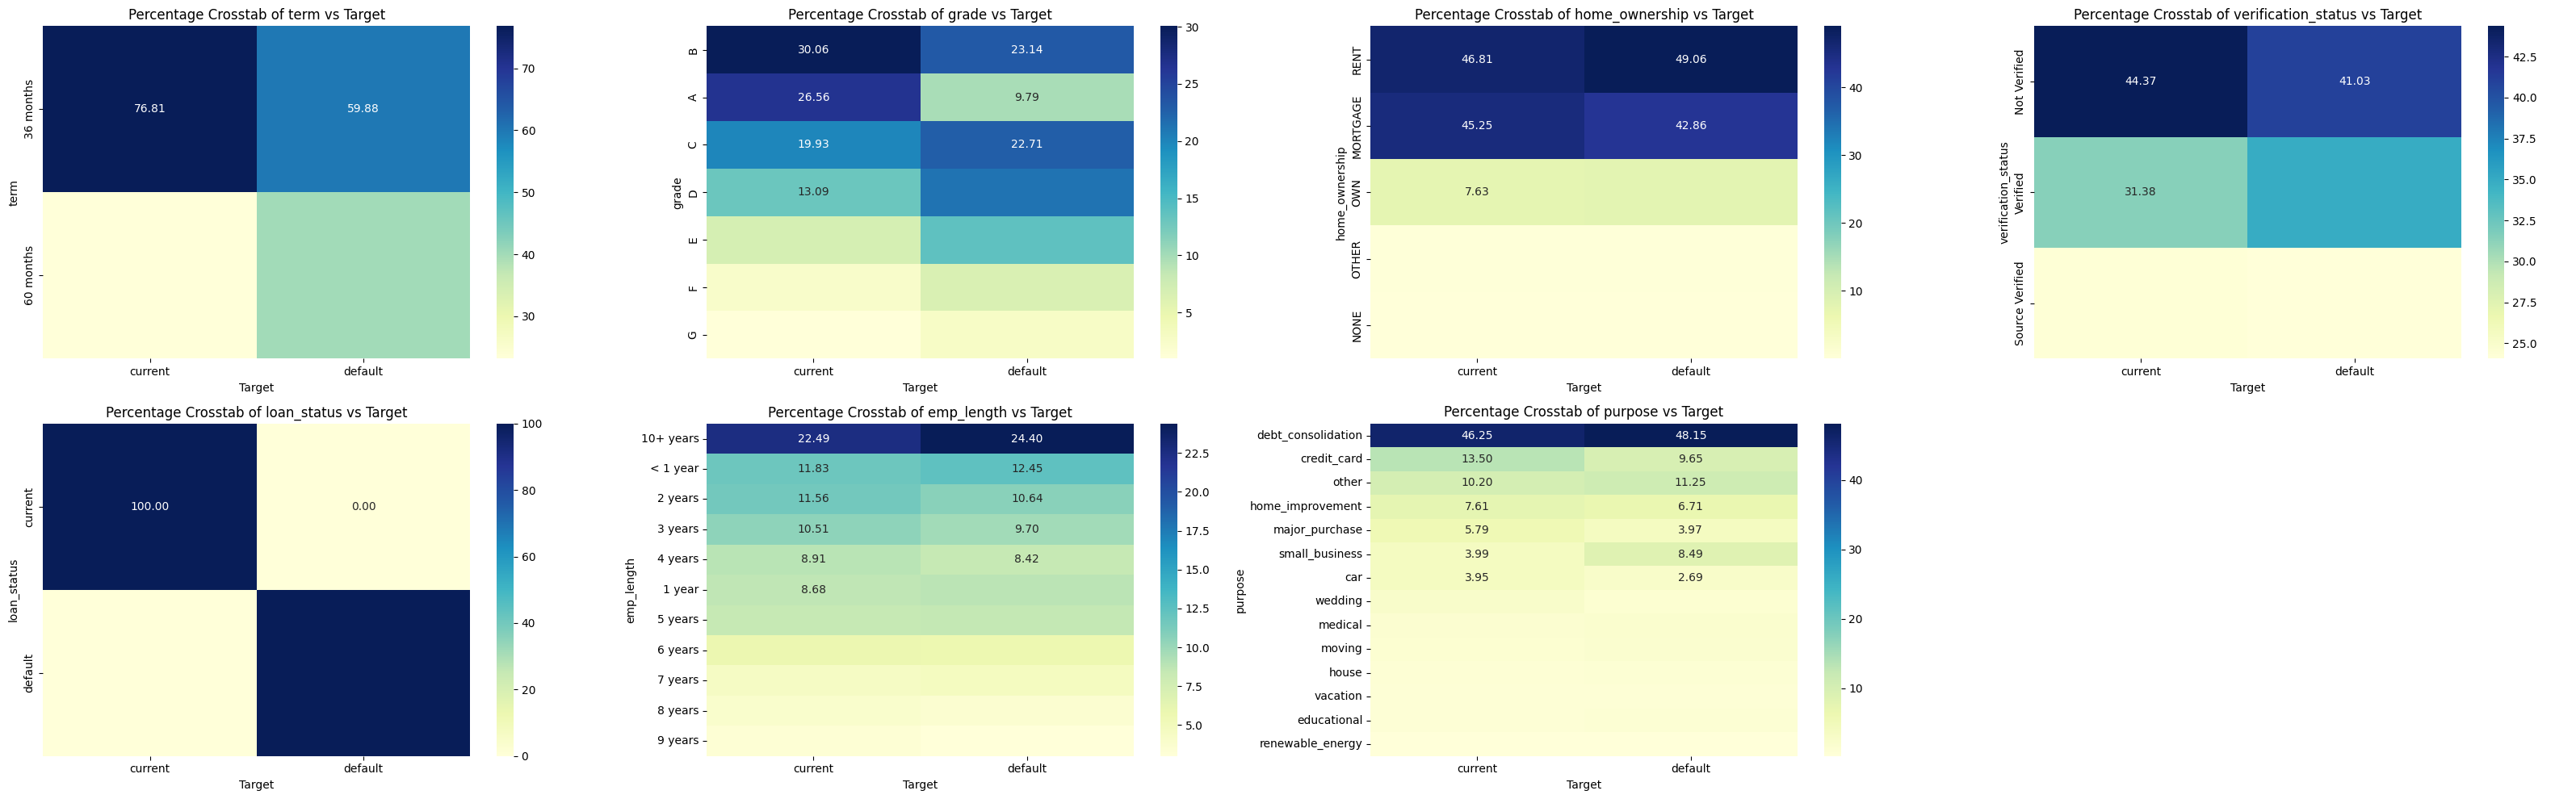

In [26]:
ynk.plot_percentage_crosstab(df, df['loan_status'], low_card + ['emp_length','purpose'])

## I.4 Multivariate Analysis

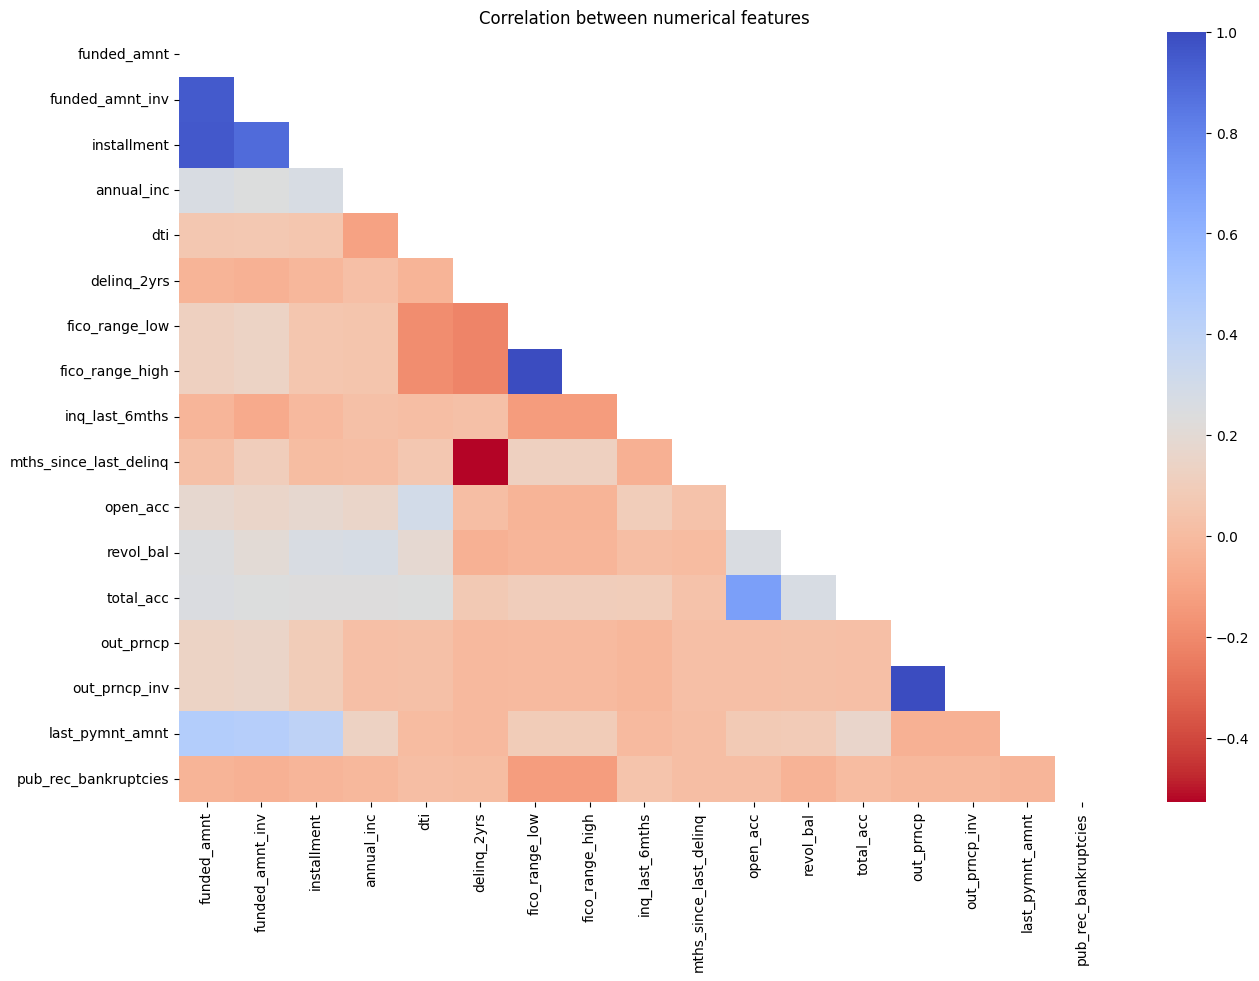

In [27]:
# check the correlation between numerical features
correlation = df[numerical_features].corr()

plt.figure(figsize=(15, 10))
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask the upper triangle
sns.heatmap(correlation, annot=True, cmap='coolwarm_r', mask=mask)
plt.title('Correlation between numerical features')
plt.show()

Some numerical features are highly correlated with one another. We can consider removing some of them to avoid multicollinearity

# II. Feature Engineering

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'], test_size=0.2, random_state=42)

In [29]:
# get the data ready for model building
X_train = dp.feature_engineering_pipeline(X_train)

X_test = dp.feature_engineering_pipeline(X_test)

y_train = dp.convert_target_to_numerical(y_train)

y_test = dp.convert_target_to_numerical(y_test)


# III. Model Building 

In [30]:
# update numerical and categorical features list 
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()


In [31]:
# Create a pipeline to preprocess the data 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## III. 1 Logisitic Regression

In [32]:
# execute the pipeline
lr_pipeline = ynk.train_model(LogisticRegression(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
lr_pred, lr_pred_prob = ynk.get_predictions(lr_pipeline, X_test)

# obtain performance 
lr_performance = PerformanceMetrics(y_test, lr_pred, lr_pred_prob)

# print out the performance
lr_performance.print_performance_metrics('Logistic Regression')

Performance Metrics of the model Logistic Regression: 

Accuracy: 0.9134
Precision: 0.7438
Recall: 0.6596
ROC AUC: 0.9483
F1 Score: 0.6992


## III. 2 Random Forest

In [33]:
# execute the pipeline
rf_pipeline = ynk.train_model(RandomForestClassifier(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
rf_pred, rf_pred_prob = ynk.get_predictions(rf_pipeline, X_test)

# obtain performance 
rf_performance = PerformanceMetrics(y_test, rf_pred, rf_pred_prob)

# print out the performance
rf_performance.print_performance_metrics('Base Random Forest')

Performance Metrics of the model Base Random Forest: 

Accuracy: 0.9010
Precision: 0.8042
Recall: 0.4645
ROC AUC: 0.9473
F1 Score: 0.5889


### III. 2.1 Random Forest Tunning

In [34]:
# rf_best_params = ynk.tune_rf_rs(rf_pipeline, X_train, y_train)

# print(rf_best_params)

With this best params from the random search, we can narrow the search space down, and apply grid search on neighbor values to find the optimal values

In [35]:
# rf_best_params = ynk.tune_rf_gs(rf_pipeline, X_train, y_train)

In [36]:
# # Create the RandomForestClassifier with the best parameters

# rf_best_params = {k.replace('classifier__', ''): v for k, v in rf_best_params.items()}

# tuned_rf_classifier = RandomForestClassifier(random_state=0, **rf_best_params)

# # apply the best hyperparameters to the random forest model
# tuned_rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ('classifier', tuned_rf_classifier)])

# # fit the model to the training data
# tuned_rf_pipeline.fit(X_train, y_train)

In [37]:
# # export the model to a pickle file 
# tuned_rf_pkl = './models/tuned_rf_pipeline.pkl'
# with open(tuned_rf_pkl, 'wb') as file:
#     pickle.dump(tuned_rf_pipeline, file)

In [38]:
# import the tuned random forest model from the pickle file
with open('./models/tuned_rf_pipeline.pkl', 'rb') as file:
    tuned_rf_pipeline = pickle.load(file)

In [39]:
tuned_rf_pred, tuned_rf_pred_prob = ynk.get_predictions(tuned_rf_pipeline, X_test)

# obtain performance 
tuned_rf_performance = PerformanceMetrics(y_test, tuned_rf_pred, tuned_rf_pred_prob)

# print out the performance
tuned_rf_performance.print_performance_metrics('Tuned Random Forest')

Performance Metrics of the model Tuned Random Forest: 

Accuracy: 0.8968
Precision: 0.7967
Recall: 0.4346
ROC AUC: 0.9506
F1 Score: 0.5624


## III. 3 XGBoost

In [40]:
# execute the pipeline
xgb_pipeline = ynk.train_model(XGBClassifier(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
xgb_pred, xgb_pred_prob = ynk.get_predictions(xgb_pipeline, X_test)

# obtain performance 
xgb_performance = PerformanceMetrics(y_test, xgb_pred, xgb_pred_prob)

# print out the performance
xgb_performance.print_performance_metrics('Base XGBoost')

Performance Metrics of the model Base XGBoost: 

Accuracy: 0.9212
Precision: 0.7633
Recall: 0.7007
ROC AUC: 0.9568
F1 Score: 0.7306


### III. 3.1 XGBoost Tunning

In [41]:
# xgb_best_params = ynk.tune_xgb_rs(xgb_pipeline, X_train, y_train)
# print(xgb_best_params)

With the best params from the random search, we can narrow the search space down, and apply grid search on neighbor values to find the optimal values

In [42]:
# xgb_best_params = ynk.tune_xgb_gs(xgb_pipeline, X_train, y_train)

In [43]:
# # Create the xgboost with the best parameters

# xgb_best_params = {k.replace('classifier__', ''): v for k, v in xgb_best_params.items()}

# tuned_xgb_classifier = XGBClassifier(random_state=0, **xgb_best_params)

# # apply the best hyperparameters to the random forest model
# tuned_xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ('classifier', tuned_xgb_classifier)])

# # fit the model to the training data
# tuned_xgb_pipeline.fit(X_train, y_train)

In [44]:
# # export the model to a pickle file 
# tuned_xgb_pkl = './models/tuned_xgb_pipeline.pkl'
# with open(tuned_xgb_pkl, 'wb') as file:
#     pickle.dump(tuned_xgb_pipeline, file)

In [45]:
# import the tuned xgb model from the pickle file
with open('./models/tuned_xgb_pipeline.pkl', 'rb') as file:
    tuned_xgb_pipeline = pickle.load(file)

Now make predictions and obtain eval metrics on the tuned model 

In [46]:
tuned_xgb_pred, tuned_xgb_pred_prob = ynk.get_predictions(tuned_xgb_pipeline, X_test)

# obtain performance 
tuned_xgb_performance = PerformanceMetrics(y_test, tuned_xgb_pred, tuned_xgb_pred_prob)

# pri_xgbout the performance
tuned_xgb_performance.print_performance_metrics('Tuned XGBoost')

Performance Metrics of the model Tuned XGBoost: 

Accuracy: 0.9254
Precision: 0.7814
Recall: 0.7095
ROC AUC: 0.9603
F1 Score: 0.7438


## III. 4 Neural Network

In [47]:
# get the number of dimension after transform in the pipeline
print('Number of features after one-hot encoding:', len(rf_pipeline.named_steps['preprocessor'].transform(X_train).toarray()[0]))

Number of features after one-hot encoding: 129


In [48]:
# Step 1: Define a function that returns a Keras model

def create_model():
    model = Sequential()
    model.add(Dense(129, input_dim = 129, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Step 2: Wrap the Keras model with KerasClassifier (you may need to install scikeras first)
neural_network = KerasClassifier(build_fn=create_model, epochs=100, batch_size=128, verbose=0)

# Step 3: Include the wrapped model in your pipeline
nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('nn', neural_network),
])

# Fit the model
nn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['funded_amnt',
                                                   'funded_amnt_inv', 'term',
                                                   'int_rate', 'installment',
                                                   'grade', 'emp_title',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'annual_inc',
                                                   'verification_status',
                                                   'issue_d', 'desc', 'dti',
                                                   'delinq_2yrs',
                                                   '...
                                                   'next_pymnt_d',
                                                   'last_credit_pull_d',
                                                   'pub_rec_bankruptcies']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sub_grade', 'purpose',
                                                   'addr_state'])])),
                ('nn',
                 KerasClassifier(batch_size=128, build_fn=<function create_model at 0x0000025751E2F160>, epochs=100, verbose=0))])

In [49]:
# get predictions
nn_pred, nn_pred_prob = ynk.get_predictions(nn_pipeline, X_test)

# performance metrics 
nn_performance = PerformanceMetrics(y_test, nn_pred, nn_pred_prob)

# print out the performance
nn_performance.print_performance_metrics('Neural Network')

Performance Metrics of the model Neural Network: 

Accuracy: 0.8880
Precision: 0.6478
Recall: 0.5831
ROC AUC: 0.9131
F1 Score: 0.6138


### III. 4.1 Neural Network Tunning

In [50]:
# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform the training and test data using the preprocessor (the pipeline that we defined earlier)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert sparse matrices to dense tensors
X_train_processed = X_train_processed.toarray()
X_test_processed = X_test_processed.toarray()


In [51]:

# # Define a function to create a Keras model with dropout layers
# def create_model(hidden_layers=1, neurons=32, activation='relu', dropout_rate=0.2):
#     model = Sequential()
#     model.add(Dense(128, input_dim=X_train_processed.shape[1]))  
#     model.add(Dense(neurons, activation=activation))
#     model.add(Dropout(dropout_rate))
#     for _ in range(hidden_layers):
#         model.add(Dense(neurons, activation=activation)) 
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])  
#     return model

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# # Define the hyperparameters grid including dropout rate and number of epochs
# param_grid = {
#     'hidden_layers': [2, 3, 4],      
#     'neurons': [32, 64, 128],        
#     'dropout_rate': [0.1, 0.2, 0.3, 0.4],
#     'epochs': [50, 100, 150],       
# }

# # Perform grid search manually
# best_score = 0
# best_params = None
# for hidden_layers in param_grid['hidden_layers']:
#     for neurons in param_grid['neurons']:
#         for dropout_rate in param_grid['dropout_rate']:
#             for epochs in param_grid['epochs']:
#                 # Create and compile the model
#                 model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)
                
#                 # Train the model
#                 model.fit(X_train_processed, y_train, epochs=epochs, validation_data=(X_test_processed, y_test), callbacks=[early_stopping], verbose=2)
                
#                 # Evaluate the model
#                 _, _, recall = model.evaluate(X_test_processed, y_test, verbose=0)  
                
#                 # Check if this is the best model so far
#                 if recall > best_score:  
#                     best_score = recall
#                     best_params = {'hidden_layers': hidden_layers,
#                                    'neurons': neurons,
#                                    'dropout_rate': dropout_rate,
#                                    'epochs': epochs}

# print("Best Parameters:", best_params)
# print("Best Recall:", best_score)


In [52]:
# optimal_epochs = best_params['epochs']
# # remove the epochs from the best_params
# best_params.pop('epochs')

In [53]:
# tuned_nn = create_model(**best_params)
# # train the the optimal nn model 
# tuned_nn.fit(X_train_processed, y_train, epochs=optimal_epochs, validation_data=(X_test_processed, y_test), callbacks=[early_stopping], verbose=2)

In [54]:
# # export the model to a pickle file
# tuned_nn_pkl = './models/tuned_nn.pkl'
# with open(tuned_nn_pkl, 'wb') as file:
#     pickle.dump(tuned_nn, file)

In [55]:
# import the tuned xgb model from the pickle file
with open('./models/tuned_nn.pkl', 'rb') as file:
    tuned_nn = pickle.load(file)

Now make predictions and obtain eval metrics on the tuned model 

In [56]:
# get predictions 
tuned_nn_pred_prob = tuned_nn.predict(X_test_processed)
tuned_nn_pred = (tuned_nn_pred_prob > 0.5).astype(int)

# obtain performance
tuned_nn_performance = PerformanceMetrics(y_test, tuned_nn_pred, tuned_nn_pred_prob)

# print out the performance
tuned_nn_performance.print_performance_metrics('Tuned Neural Network')


185/185 [==============================] - 0s 912us/step
Performance Metrics of the model Tuned Neural Network: 

Accuracy: 0.8895
Precision: 0.5951
Recall: 0.8636
ROC AUC: 0.9414
F1 Score: 0.7047


Merge all the performance metrics together

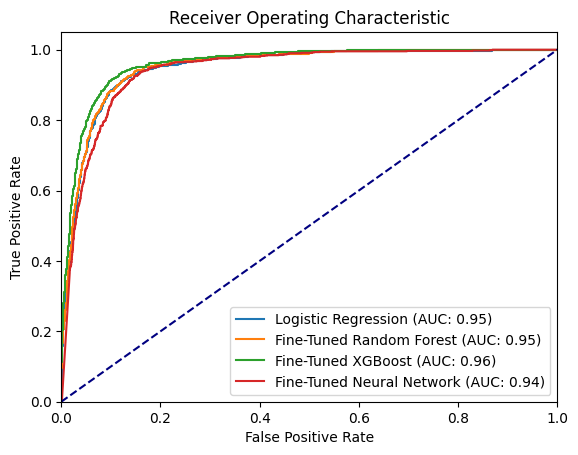

In [57]:
ynk.plot_roc_curve([lr_performance.y_pred_prob, 
                    tuned_rf_performance.y_pred_prob, 
                    tuned_xgb_performance.y_pred_prob,
                    tuned_nn_performance.y_pred_prob], 
                   ['Logistic Regression', 
                    'Fine-Tuned Random Forest',
                    'Fine-Tuned XGBoost', 
                    'Fine-Tuned Neural Network'], 
                   y_test)

## III. 5 Stacking Classifier

In this stacking classifier, we will use the best models from the previous section to build a new model. Also, we included gradient boosting (GBM) as an additional model in the stack. Params used in these model have already been tuned in the previous section

In [58]:
stacked_pipeline = create_stacking_classifier(preprocessor=preprocessor)

In [59]:
stacked_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['funded_amnt',
                                                   'funded_amnt_inv', 'term',
                                                   'int_rate', 'installment',
                                                   'grade', 'emp_title',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'annual_inc',
                                                   'verification_status',
                                                   'issue_d', 'desc', 'dti',
                                                   'delinq_2yrs',
                                                   '...
                                                               min_child_weight=5,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('rf',
                                                 RandomForestClassifier(bootstrap=False,
                                                                        max_depth=40,
                                                                        min_samples_leaf=5,
                                                                        min_samples_split=50,
                                                                        n_estimators=1100,
                                                                        random_state=0)),
                                                ('lr',
                                                 LogisticRegression(random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

In [60]:
# # export the model to a pickle file
# stacked_pkl = './models/stacked.pkl'
# with open(stacked_pkl, 'wb') as file:
#     pickle.dump(stacked_pipeline, file)

In [61]:
# import the stacked model in 
with open('./models/stacked.pkl', 'rb') as file:
    stacked_pipeline = pickle.load(file)

In [62]:
# obtain prediction 
stacked_pred, stacked_pred_prob = ynk.get_predictions(stacked_pipeline, X_test)

# obtain performance 
stacked_performance = PerformanceMetrics(y_test, stacked_pred, stacked_pred_prob)

# print out the performance
stacked_performance.print_performance_metrics('Stacking Classifier')

Performance Metrics of the model Stacking Classifier: 

Accuracy: 0.9210
Precision: 0.7836
Recall: 0.6663
ROC AUC: 0.9569
F1 Score: 0.7202


# IV. Model Evaluation

## IV. 1 Global Model Explanations

Merge all the eval metrics for all models together

In [63]:
metrics_tbl = pd.concat([create_metrics_dataframe(lr_performance, 'Logistic Regression'),
                         create_metrics_dataframe(rf_performance, 'Random Forest'),
                         create_metrics_dataframe(tuned_rf_performance, 'Tuned Random Forest'),
                         create_metrics_dataframe(xgb_performance, 'XGBoost'),
                         create_metrics_dataframe(tuned_xgb_performance, 'Tuned XGBoost'),
                         create_metrics_dataframe(nn_performance, 'Neural Network'),
                         create_metrics_dataframe(tuned_nn_performance, 'Tuned Neural Network'),
                         create_metrics_dataframe(stacked_performance, 'Stacking Classifier')])

metrics_tbl                         

,accuracy,precision,recall,roc_auc,f1_score
Logistic Regression,0.913396,0.743750,0.659645,0.948273,0.699177
Random Forest,0.901049,0.804223,0.464523,0.947328,0.588897
Tuned Random Forest,0.896820,0.796748,0.434590,0.950632,0.562410
XGBoost,0.921177,0.763285,0.700665,0.956824,0.730636
Tuned XGBoost,0.925406,0.781441,0.709534,0.960297,0.743754
Neural Network,0.888024,0.647783,0.583149,0.913066,0.613769
Tuned Neural Network,0.889547,0.595111,0.863636,0.941404,0.704659
Stacking Classifier,0.921008,0.783572,0.666297,0.956909,0.720192


Since we apply standard scaling to the numerical features, we can use the coefficients from the logistic regression to interpret the importance of the features. We can also use the feature importance from the random forest and xgboost to interpret the importance of the features

### IV. 1.1 Feature Importance

`Logisi Regression`

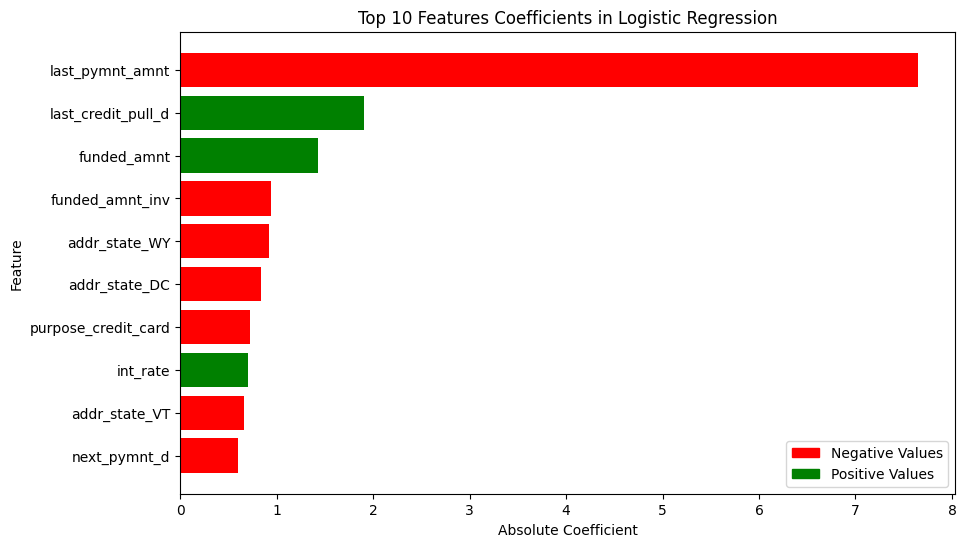

In [64]:
ynk.plot_lr_fi(lr_pipeline)

`Random Forest`

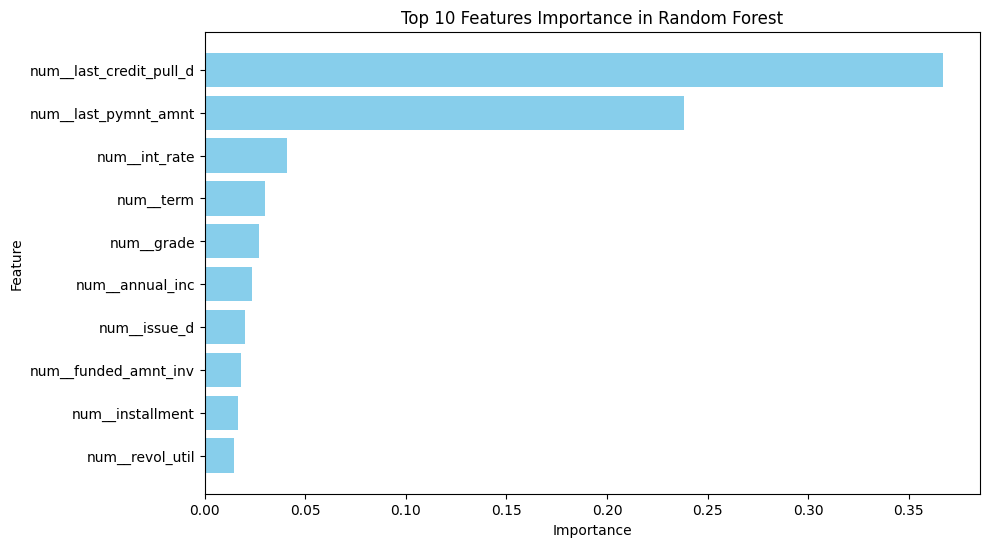

In [65]:
ynk.plot_tree_fi(tuned_rf_pipeline)

`XGBoost`

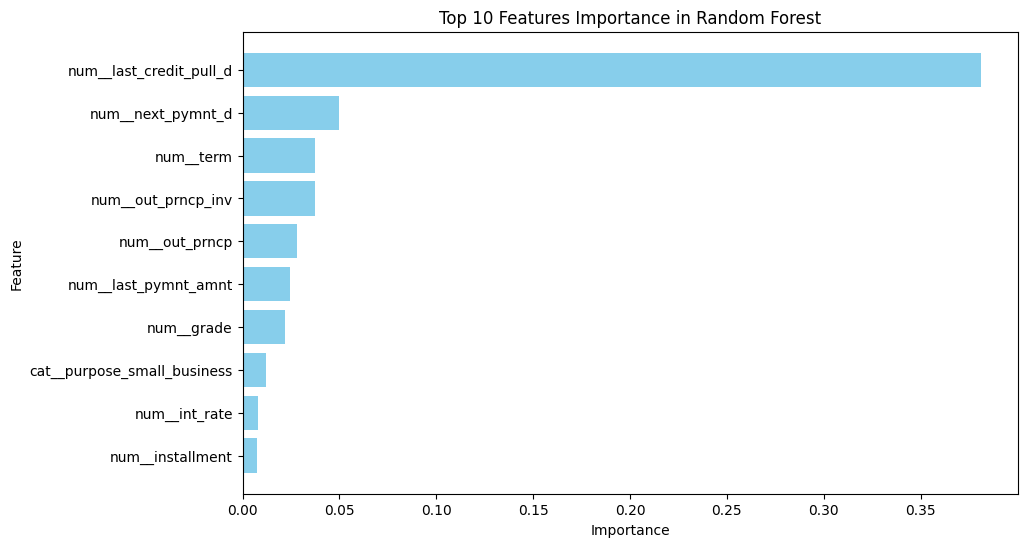

In [66]:
ynk.plot_tree_fi(tuned_xgb_pipeline)

### IV. 1.2 ROC Curve & PR Curve

Visualize the roc curve for 5% FPR for our top models

In [67]:
top_models_pred = {'Logistic Regression': lr_performance.y_pred_prob, 
              'Tuned Random Forest': tuned_rf_performance.y_pred_prob, 
              'Tuned XGBoost': tuned_xgb_performance.y_pred_prob,
              'Tuned Neural Network': tuned_nn_performance.y_pred_prob,
              'Stacking Classifier' : stacked_performance.y_pred_prob}

ROC and PR curve for Logistic Regression


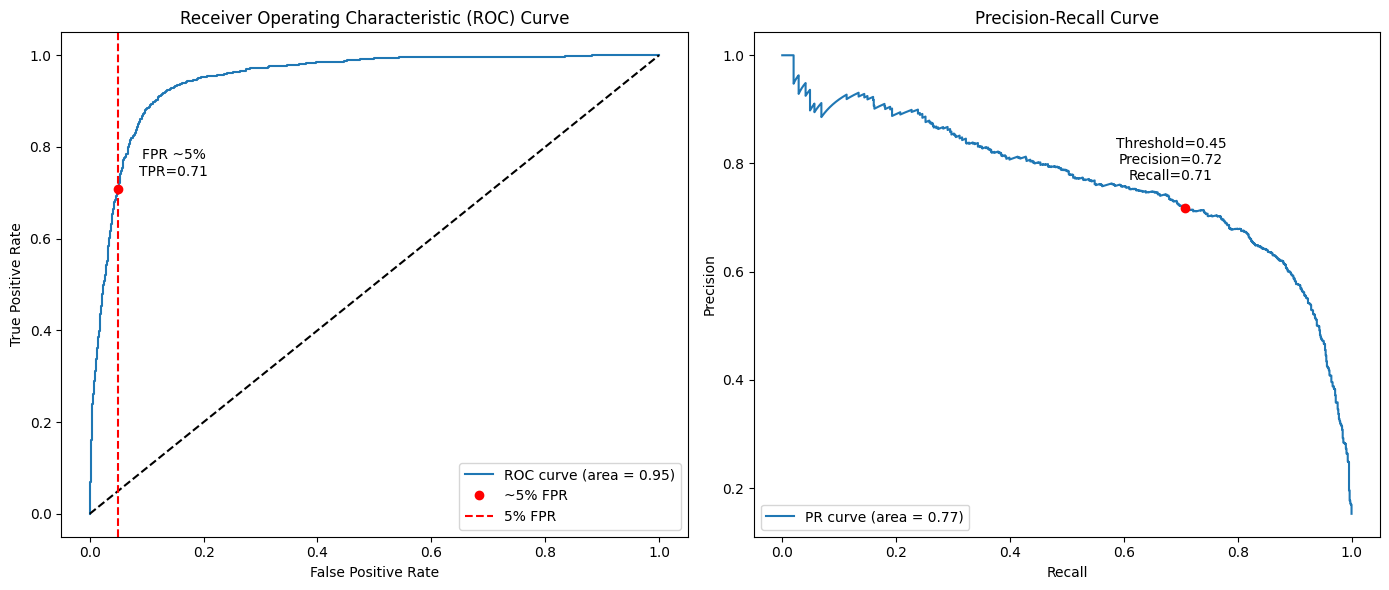



ROC and PR curve for Tuned Random Forest


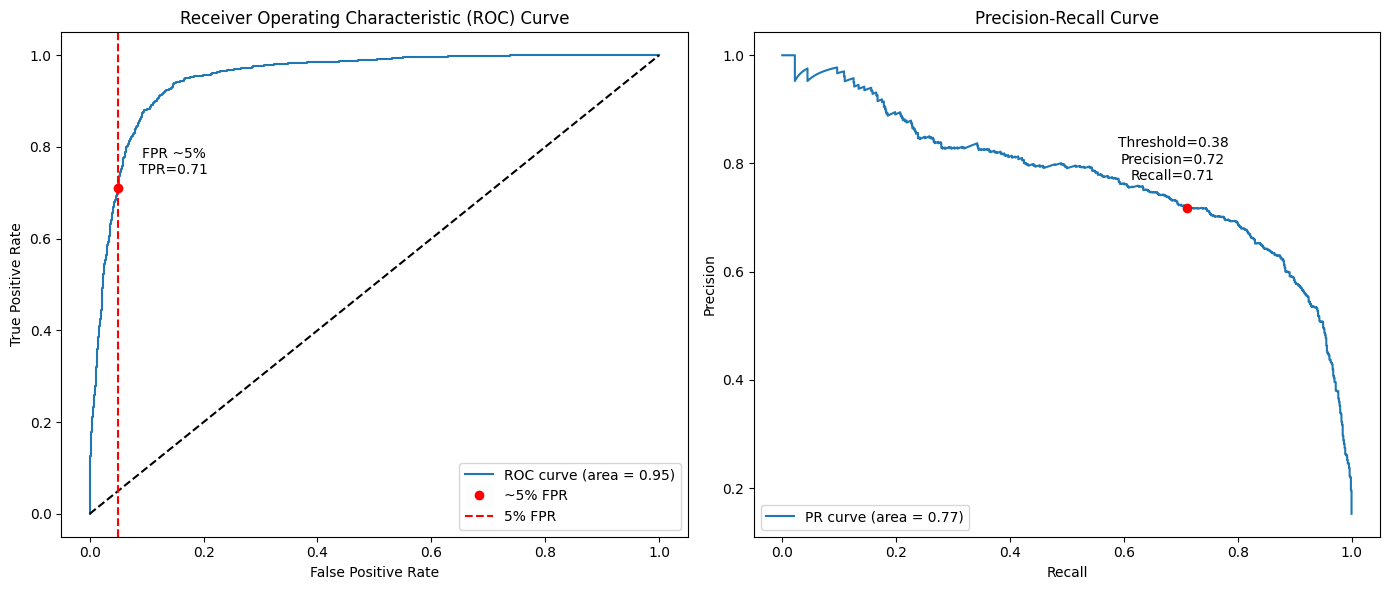



ROC and PR curve for Tuned XGBoost


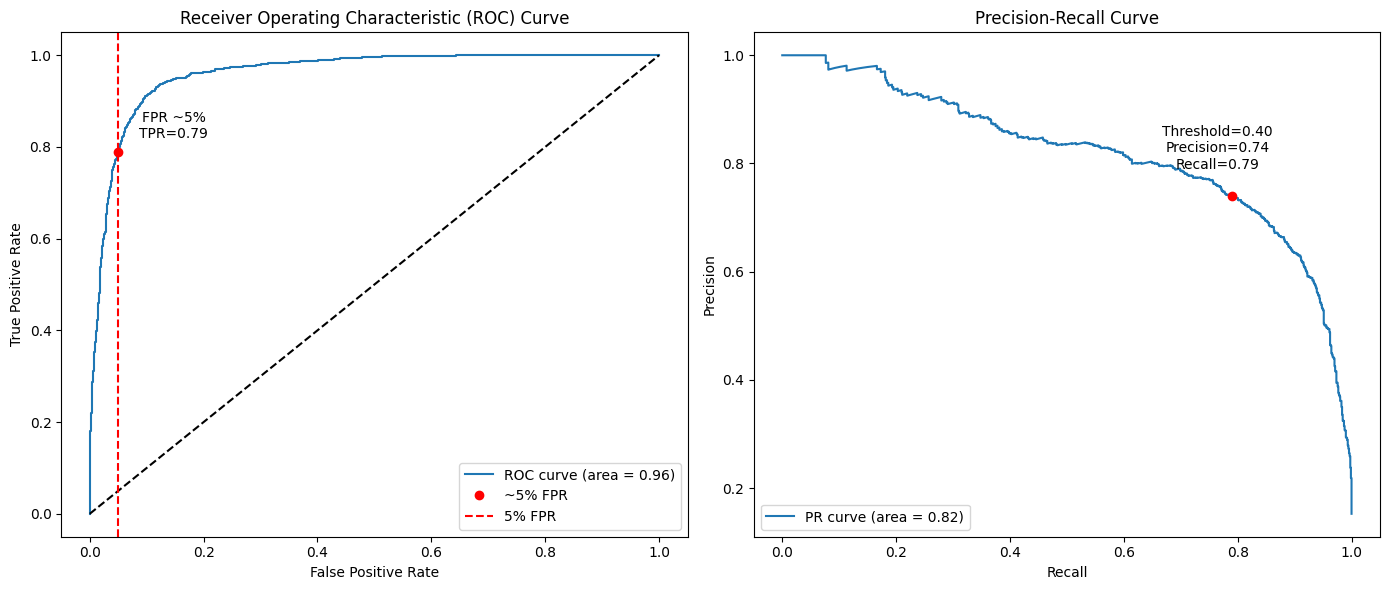



ROC and PR curve for Tuned Neural Network


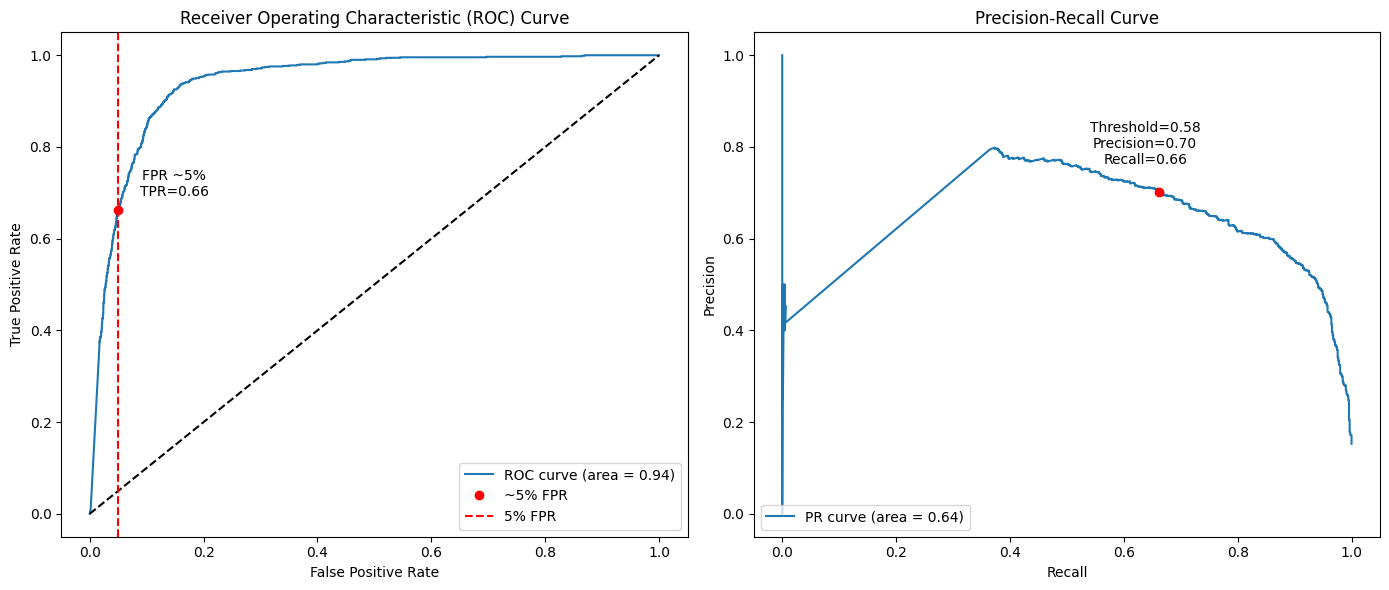



ROC and PR curve for Stacking Classifier


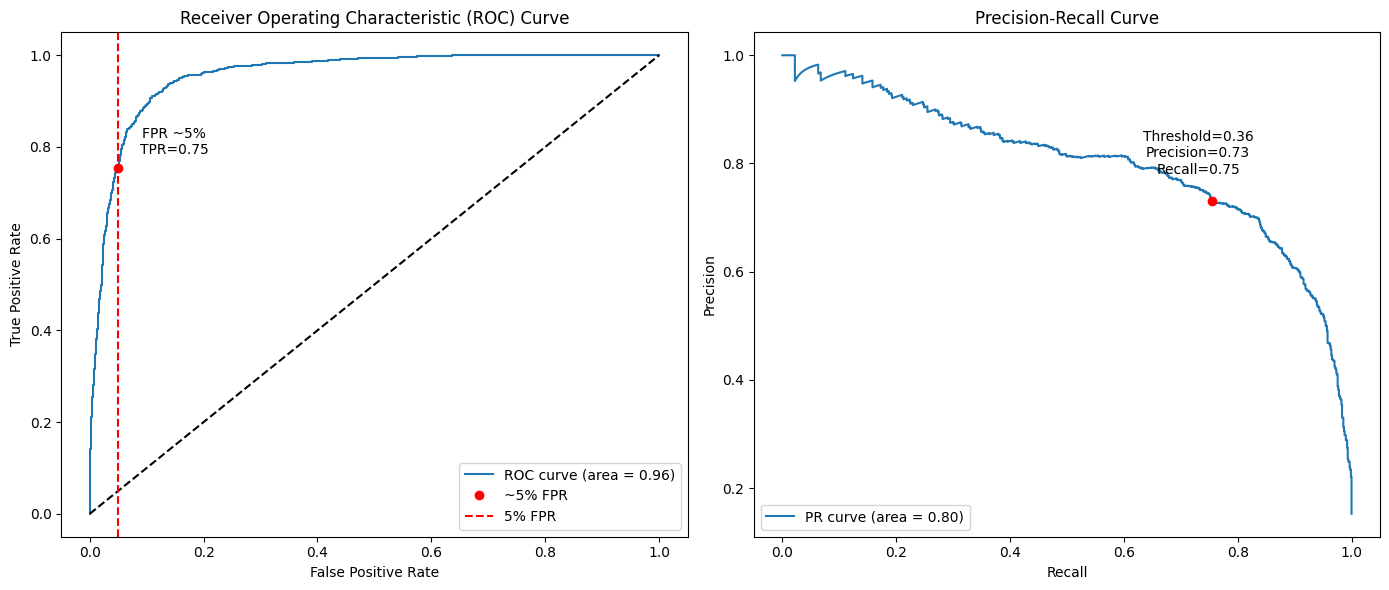

In [68]:
for model, pred in top_models_pred.items():
    print(f'ROC and PR curve for {model}')
    ynk.plot_roc_pr_curves(y_test, pred, fpr_percentile= 5)
    print('\n')

Visualize the roc curve for 2% FPR for our top models

ROC and PR curve for Logistic Regression


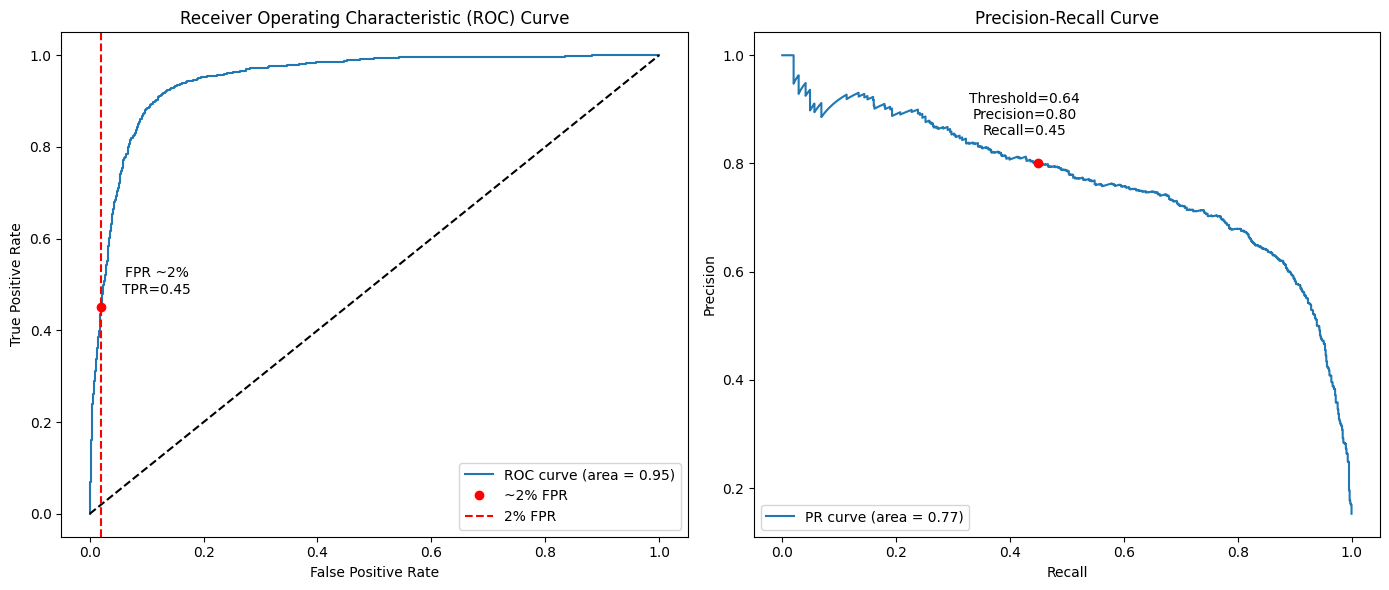



ROC and PR curve for Tuned Random Forest


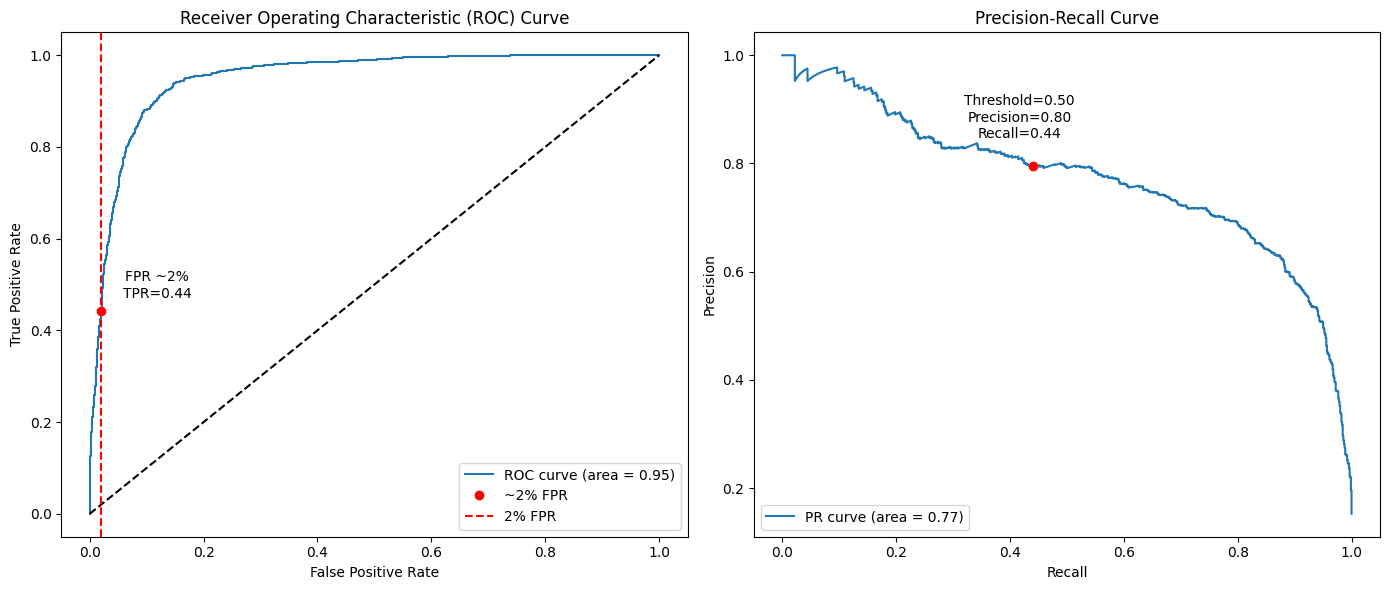



ROC and PR curve for Tuned XGBoost


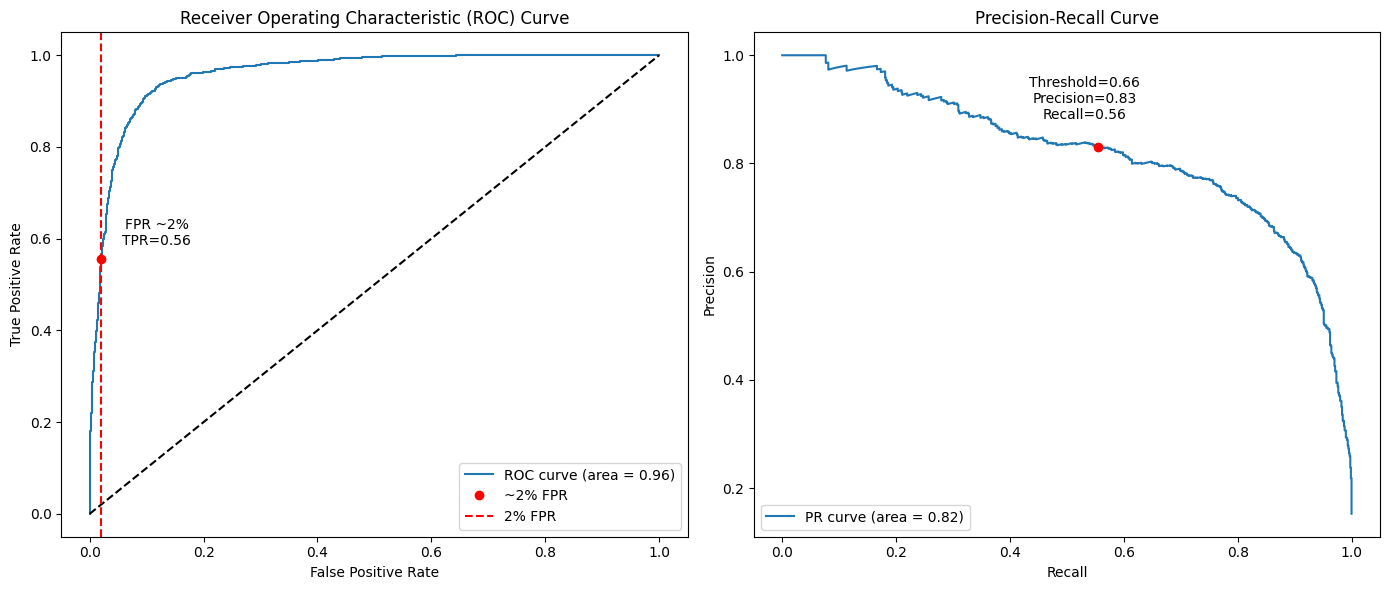



ROC and PR curve for Tuned Neural Network


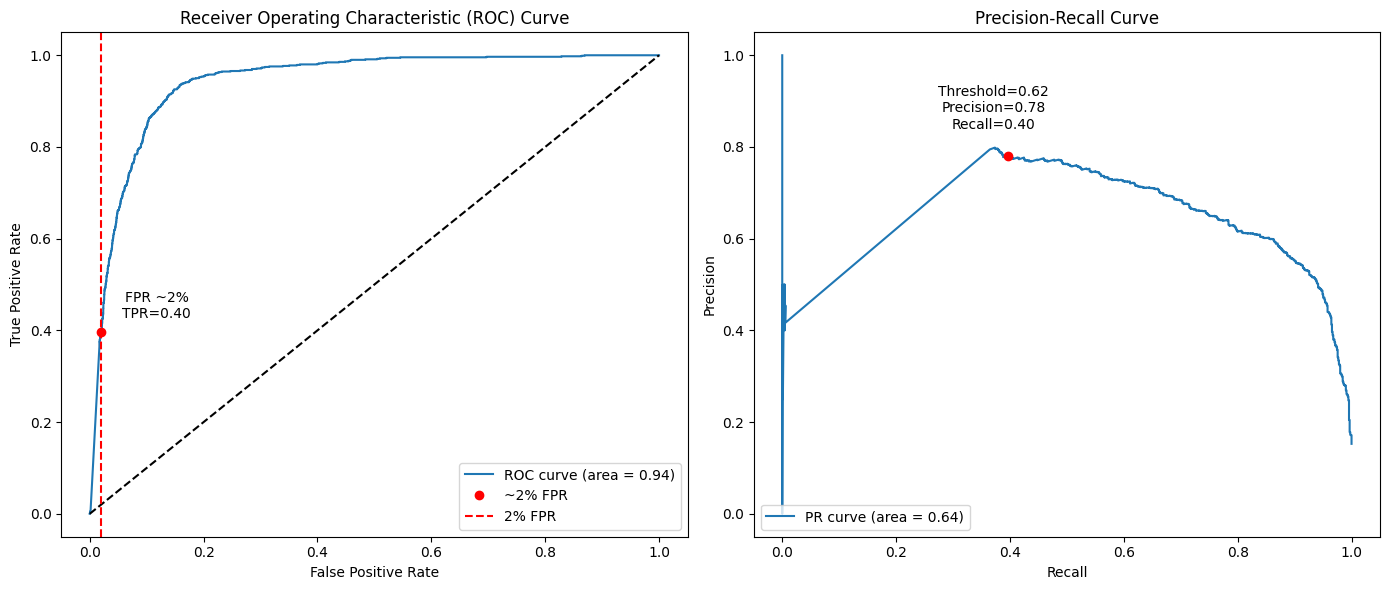



ROC and PR curve for Stacking Classifier


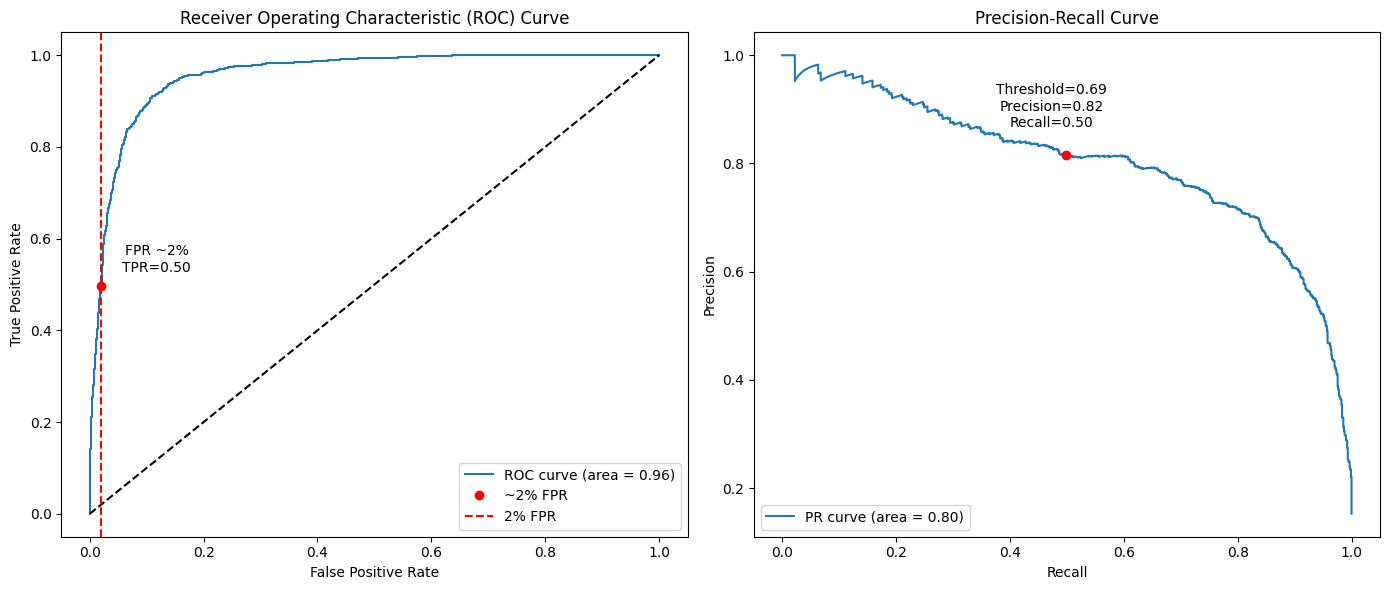

In [69]:
for model, pred in top_models_pred.items():
    print(f'ROC and PR curve for {model}')
    ynk.plot_roc_pr_curves(y_test, pred, fpr_percentile= 2)
    print('\n')

### IV. 1.3 Partial Dependence Plot

`Numerical Features`

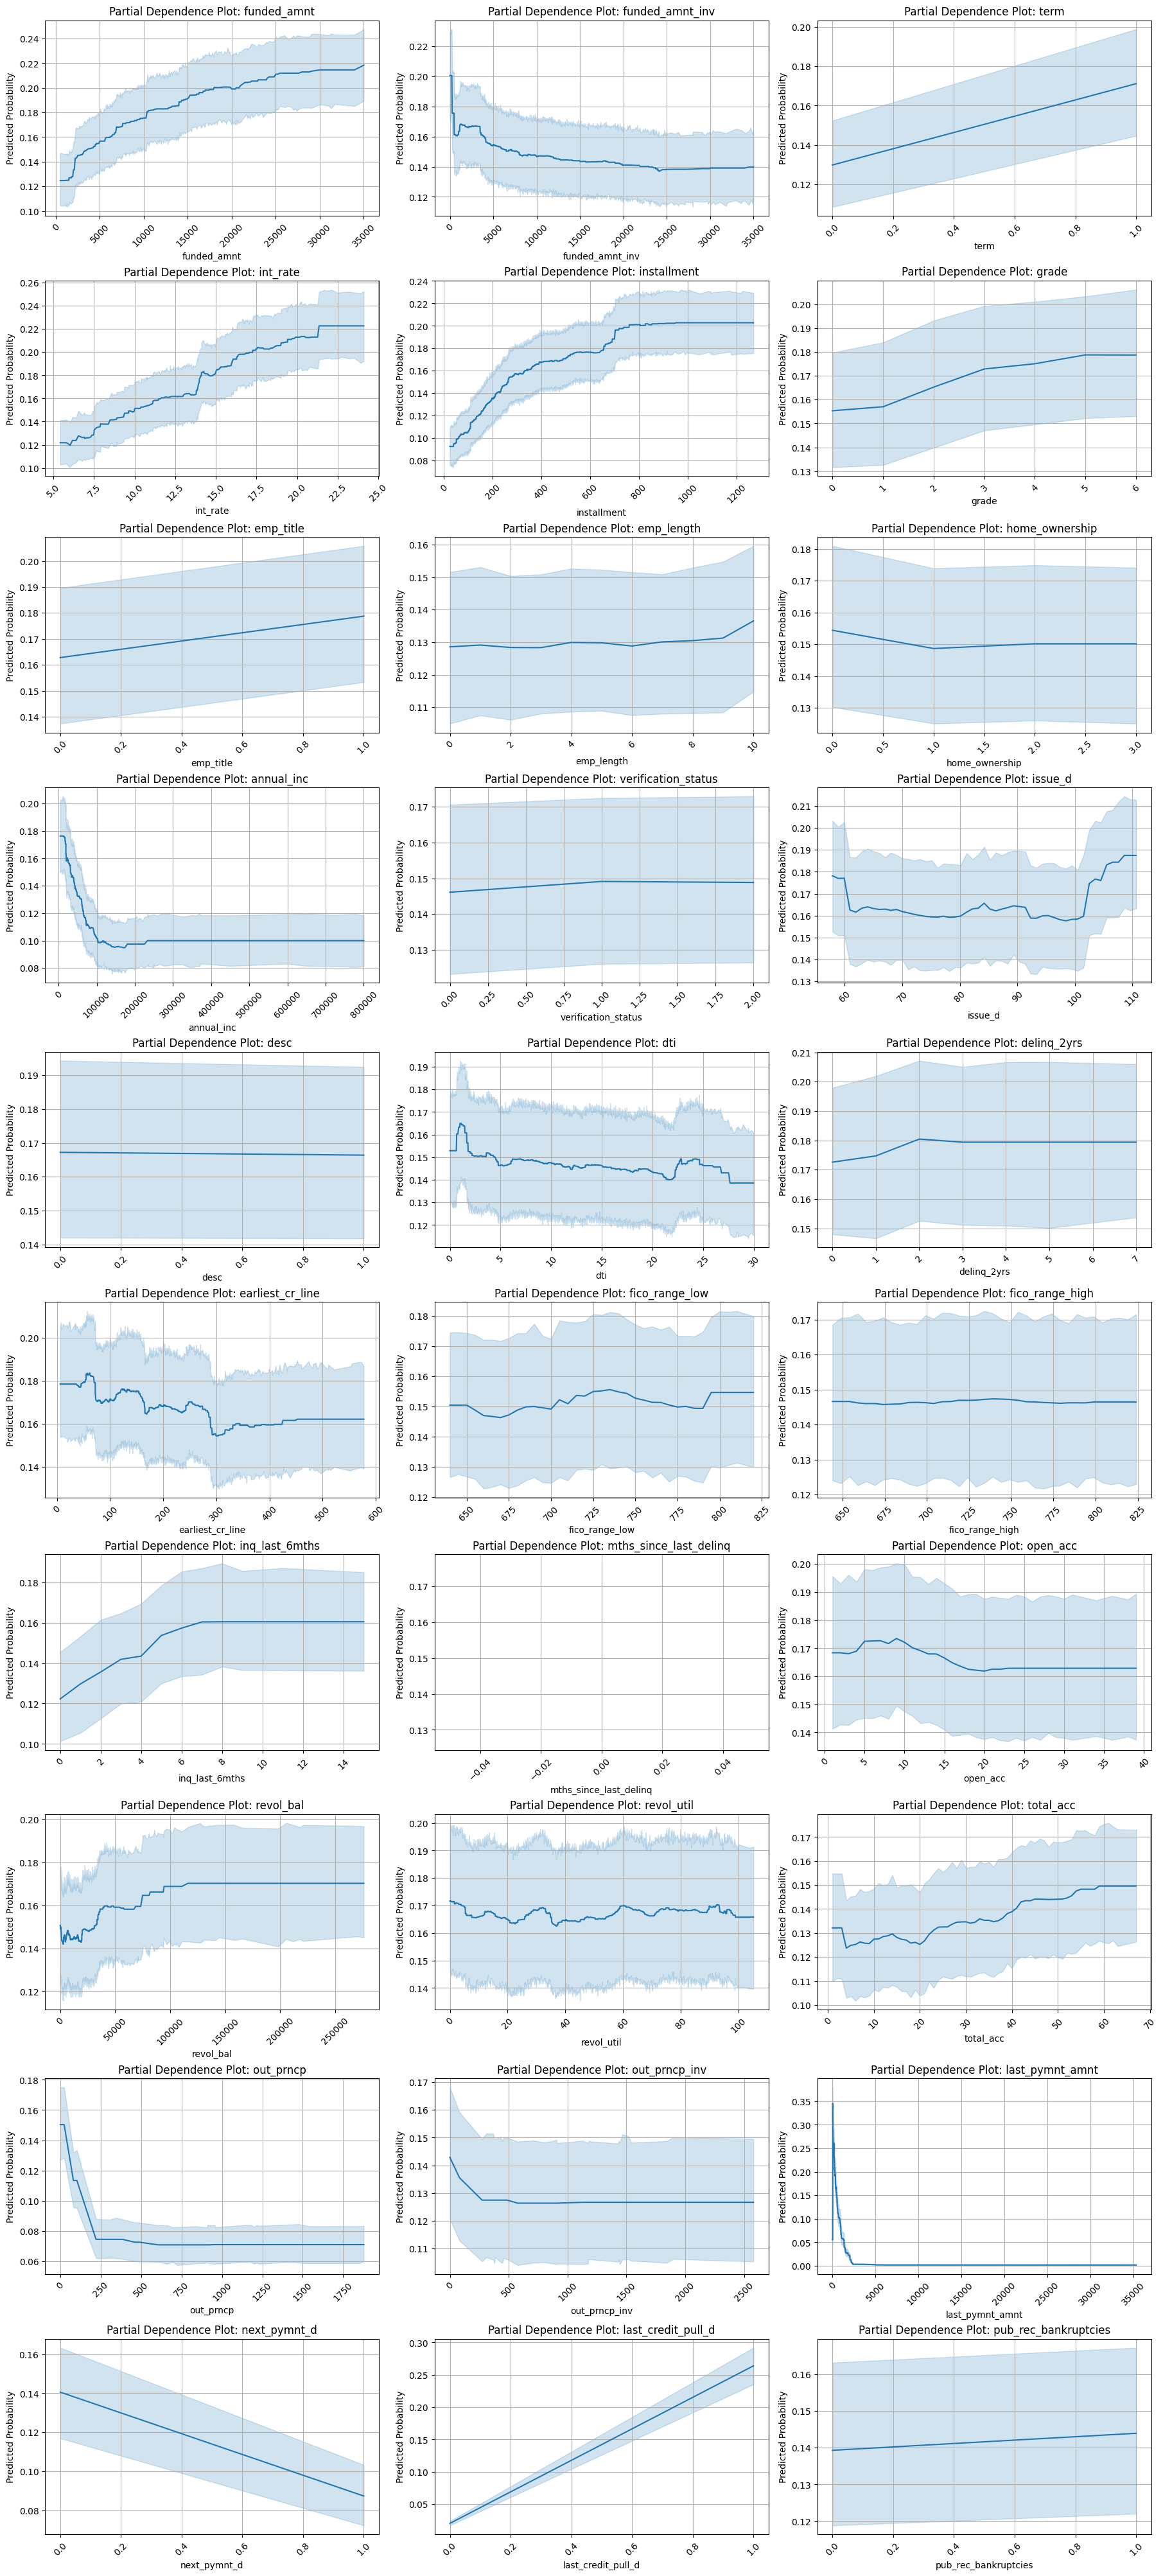

In [70]:
num_rows = (len(numerical_features) + 2) // 3 

# Create subplots with three columns, creating all subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, 4*num_rows), constrained_layout=True)

# Plot PDPs for each numerical feature
for i, num in enumerate(numerical_features):
    row = i // 3
    col = i % 3
    ynk.pdp_plot_numeric(axes[row, col], X_train, num, sample_n=500, pipeline=tuned_xgb_pipeline)

# Hide unused subplots
for i in range(len(numerical_features), num_rows * 3):
    row = i // 3
    col = i % 3
    axes[row, col].axis('off')

plt.show()

`Categorical Features`

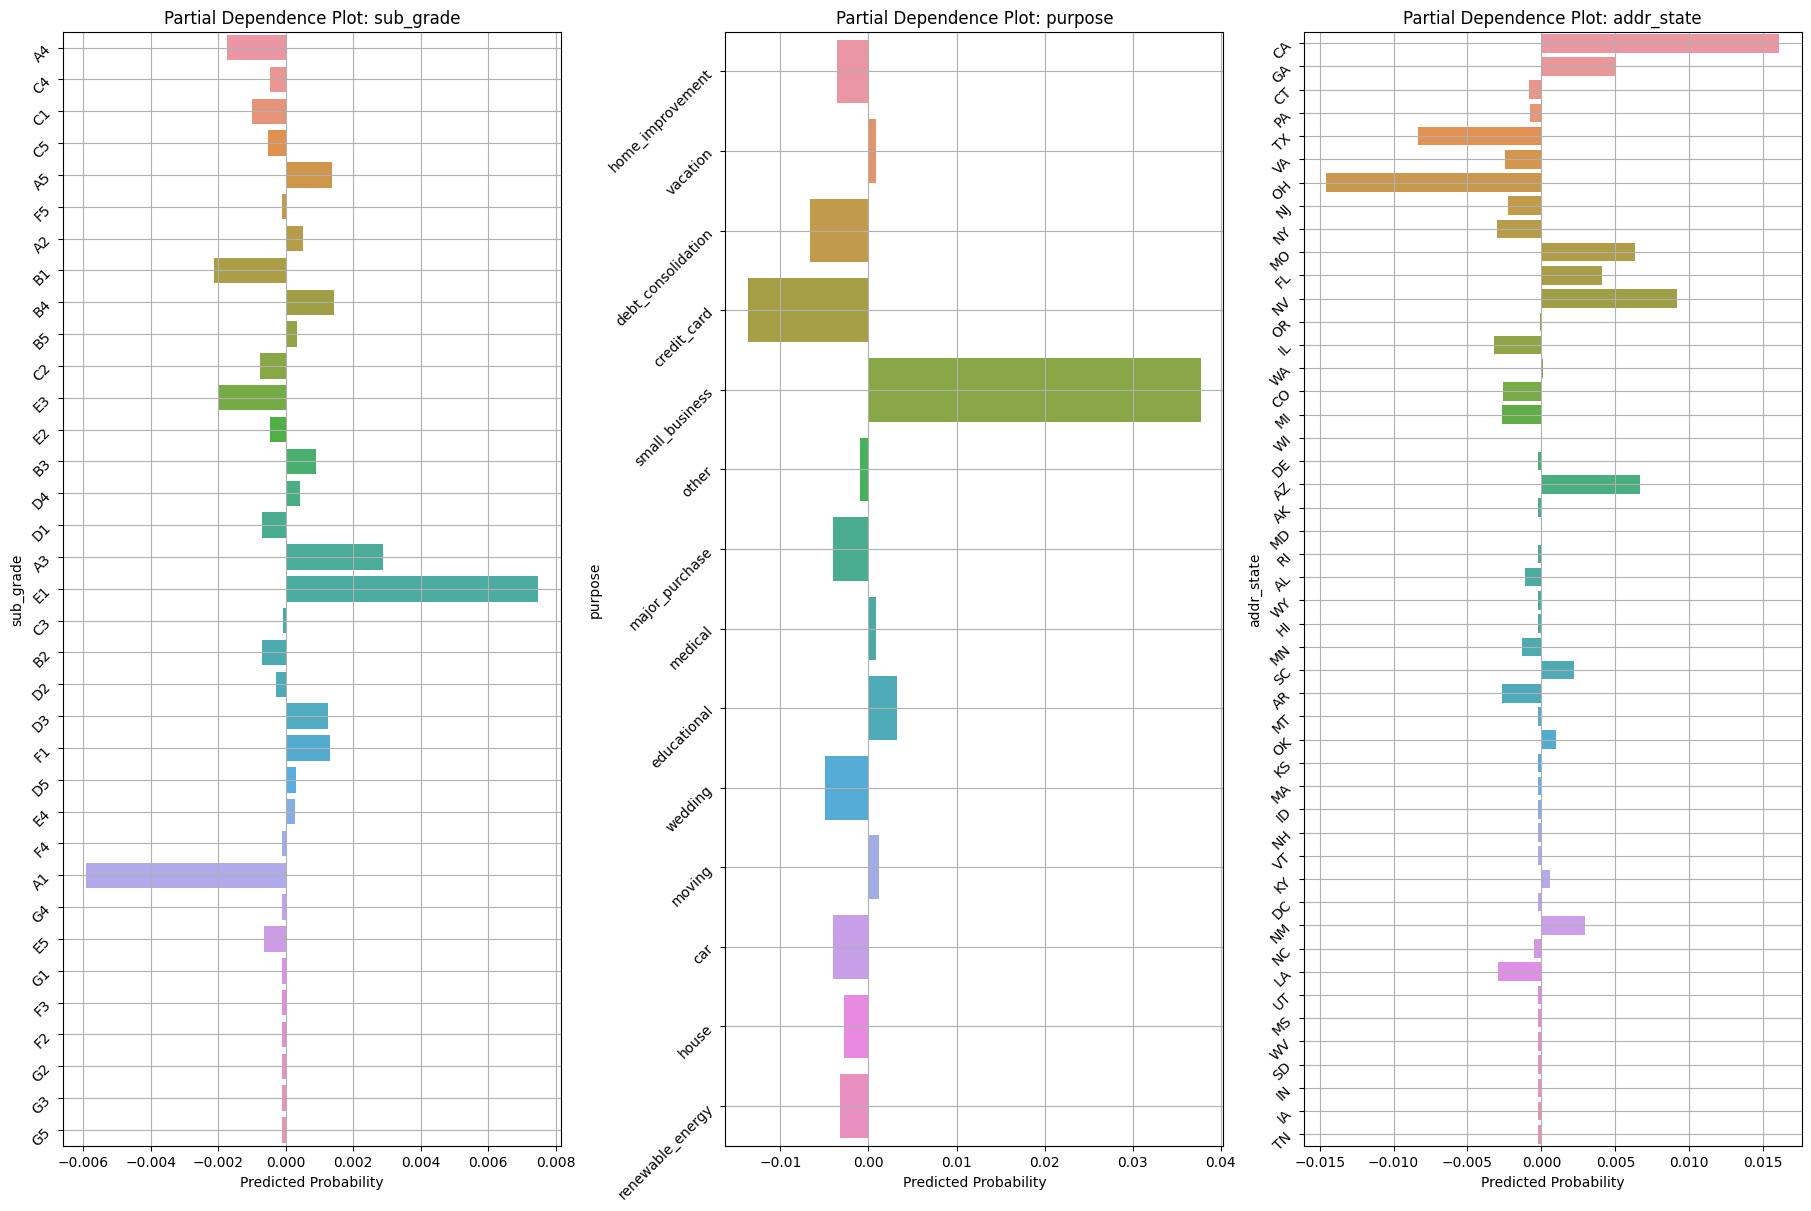

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 12), constrained_layout=True)

# Plot PDPs for each categorical feature
for i, var in enumerate(categorical_features[:3]):
    ynk.pdp_plot_categorical(axes[i], X_train, var, sample_n=500, pipeline=tuned_xgb_pipeline)

## IV. 2 Local Model Explanations

Well, of course XGBoost is the champion model, let's look into the local model explanation generated by this model

In [72]:
pipeline_explainer = dx.Explainer(tuned_xgb_pipeline, X_test, y_test)
pipeline_explainer

Preparation of a new explainer is initiated

  -> data              : 5912 rows 33 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5912 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000002574AF77AF0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000364, mean = 0.144, max = 0.981
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.93, mean = 0.00856, max = 0.997
  -> model_info        : package sklearn

A new explainer has been created!


### IV 2.1 Top 10 best True Positive 

In [73]:
X_test['pred']= tuned_xgb_pred
X_test['pred_proba']= tuned_xgb_pred_prob
X_test['loan_status'] = y_test

In [74]:
top_10_tp = (X_test
             .query('loan_status == pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_tp.head(10)

,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,total_acc,out_prncp,out_prncp_inv,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies,pred,pred_proba,loan_status
0,25000.0,300.005174,0,12.04,830.84,2,C5,0,4.0,1,...,2.0,0.0,0.0,830.84,0,1,1,1,0.981287,1
1,24000.0,274.997104,0,11.72,793.94,2,C4,0,0.0,0,...,10.0,0.0,0.0,793.94,0,1,0,1,0.979662,1
2,12000.0,11975.000000,1,19.03,311.49,4,E2,0,2.0,0,...,13.0,0.0,0.0,36.97,0,1,0,1,0.972376,1
3,14400.0,14300.000000,1,20.30,383.92,4,E5,1,NaN,0,...,33.0,0.0,0.0,383.92,0,1,0,1,0.971895,1
4,27575.0,27575.000000,1,17.58,693.94,3,D4,0,10.0,0,...,23.0,0.0,0.0,693.94,0,1,0,1,0.971747,1
5,15000.0,14975.000000,1,21.67,411.48,5,F3,0,2.0,2,...,20.0,0.0,0.0,412.98,0,1,0,1,0.971676,1
6,30000.0,29575.000000,1,23.13,847.96,6,G2,0,3.0,1,...,25.0,0.0,0.0,100.00,0,1,0,1,0.969432,1
7,21000.0,20975.000000,1,19.42,549.62,4,E3,1,1.0,0,...,22.0,0.0,0.0,549.62,0,1,0,1,0.969046,1
8,17000.0,16975.000000,1,17.14,423.78,4,E3,0,4.0,1,...,27.0,0.0,0.0,423.78,0,1,1,1,0.965679,1
9,26000.0,25975.000000,1,16.77,642.96,3,D2,0,10.0,0,...,14.0,0.0,0.0,642.96,0,1,0,1,0.965577,1


In [75]:
ynk.plot_local_breakdown_interactions(top_10_tp, pipeline_explainer)

### IV 2.2 Top 10 False Negative

In [76]:
top_10_fn = (X_test
             .query('loan_status != pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=True)
             .head(10)
             .reset_index(drop=True)
)
top_10_fn.head(10)

,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,total_acc,out_prncp,out_prncp_inv,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies,pred,pred_proba,loan_status
0,15925.0,15850.000000,1,20.77,428.77,6,G4,0,6.0,0,...,45.0,0.0,0.0,8480.98,0,1,0,0,0.002519,1
1,16000.0,15900.000000,1,15.58,385.53,3,D3,0,2.0,0,...,22.0,0.0,0.0,10021.06,0,1,0,0,0.003763,1
2,15000.0,14731.080000,0,10.99,491.03,1,B4,0,2.0,1,...,36.0,0.0,0.0,491.03,0,0,0,0,0.005517,1
3,13000.0,12975.000000,0,7.66,405.34,0,A5,0,3.0,1,...,34.0,0.0,0.0,405.34,0,0,0,0,0.006075,1
4,4000.0,4000.000000,0,13.99,136.70,2,C3,0,10.0,0,...,26.0,0.0,0.0,1637.09,0,1,0,0,0.006865,1
5,21600.0,21575.000000,1,14.79,511.49,2,C4,0,10.0,0,...,10.0,0.0,0.0,11328.71,0,1,0,0,0.007457,1
6,8000.0,6747.855405,1,6.17,155.30,0,A3,0,6.0,0,...,38.0,0.0,0.0,155.30,0,0,0,0,0.008447,1
7,3250.0,3166.055906,1,6.91,64.22,0,A5,0,4.0,0,...,50.0,0.0,0.0,1468.00,0,1,0,0,0.008796,1
8,3600.0,3600.000000,1,15.58,86.75,3,D3,0,5.0,1,...,22.0,0.0,0.0,1911.36,0,1,0,0,0.008897,1
9,12000.0,12000.000000,0,9.63,385.13,1,B1,0,2.0,0,...,20.0,0.0,0.0,385.13,0,0,0,0,0.010072,1


In [77]:
ynk.plot_local_breakdown_interactions(top_10_fn, pipeline_explainer)

### IV 2.3 Top 10 False Positive

In [78]:
# top 10 false positive 
top_10_fp = (X_test
             .query('loan_status != pred and loan_status == 0')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_fp.head(10)

,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,total_acc,out_prncp,out_prncp_inv,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies,pred,pred_proba,loan_status
0,20000.0,1510.130000,0,12.61,670.13,3,D1,0,3.0,1,...,13.0,0.0,0.0,678.78,0,1,0,1,0.930232,0
1,29600.0,29475.000000,1,19.69,779.13,4,E5,0,NaN,1,...,16.0,0.0,0.0,208.28,0,1,0,1,0.928819,0
2,7600.0,7575.000000,1,16.77,187.95,3,D2,0,1.0,1,...,21.0,0.0,0.0,53.19,0,1,0,1,0.914703,0
3,2825.0,1700.000000,0,9.64,90.68,1,B4,0,3.0,0,...,41.0,0.0,0.0,96.65,0,1,0,1,0.889747,0
4,5000.0,5000.000000,1,15.70,120.80,3,D4,0,0.0,0,...,27.0,0.0,0.0,102.68,0,1,0,1,0.887084,0
5,2400.0,2400.000000,1,17.19,59.90,4,E3,0,0.0,1,...,5.0,0.0,0.0,67.56,0,1,0,1,0.883561,0
6,2500.0,2489.955230,0,18.78,91.37,5,F3,0,0.0,1,...,7.0,0.0,0.0,96.14,0,1,0,1,0.882300,0
7,25000.0,24804.773795,1,13.72,578.09,2,C5,0,10.0,0,...,14.0,0.0,0.0,577.55,0,1,0,1,0.880714,0
8,10700.0,10700.000000,1,17.99,271.66,4,E1,0,1.0,1,...,8.0,0.0,0.0,270.83,0,1,0,1,0.879419,0
9,10000.0,10000.000000,1,17.14,249.28,4,E3,0,10.0,2,...,22.0,0.0,0.0,140.29,0,1,0,1,0.878064,0


In [79]:
ynk.plot_local_breakdown_interactions(top_10_fp, pipeline_explainer)